# Comparing the Different Models and Merge them

## Imports

In [1]:
import sys
sys.executable

'/Users/nbai/opt/miniconda3/bin/python'

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import torch

from scipy import stats
import seaborn as sns
import torch.nn.functional as F

## Loading Stored Prediction Results

In [4]:
save_dir = 'model_storage/'
compare = ['MLP', 'GAT', 'GCN', 'SAGE', 'HeteroGNN', 'HGT']
sets = ['val', 'test']

In [5]:
pd.read_csv('model_storage/GCN/per_class_metrics_knn.csv', sep=',')

,Unnamed: 0,Unnamed: 1,precision,recall,F1
0,test_ATT,Building Elements,0.984375,0.913043,0.947368
1,test_ATT,Urban Form Elements,0.986207,0.922581,0.953333
2,test_ATT,Gastronomy,0.909091,0.909091,0.909091
3,test_ATT,Interior Scenery,0.888889,1.000000,0.941176
4,test_ATT,Natural Features and Land-scape Scenery,0.930556,0.930556,0.930556
...,...,...,...,...,...
57,val_VAL_k,Criterion vii,0.000000,0.000000,0.000000
58,val_VAL_k,Criterion viii,0.000000,0.000000,0.000000
59,val_VAL_k,Criterion ix,0.000000,0.000000,0.000000
60,val_VAL_k,Criterion x,0.000000,0.000000,0.000000


In [6]:
preds = {}
for model in compare:
    now_dir = save_dir + model + '/'
    if model == 'GCN':
        temp_df = pd.read_csv(now_dir+'preds_knn.csv', sep='\t', index_col=0)
    else:
        temp_df = pd.read_csv(now_dir+'preds.csv', sep='\t', index_col=0)
    preds[model] = torch.tensor(np.array(temp_df))

In [12]:
metrics = {}
for model in compare:
    now_dir = save_dir + model + '/'
    metrics[model] = {}
    for s in sets:
        if model == 'GCN':
            temp_df = pd.read_csv(now_dir+'knn_'+s+'_metrics.csv', sep='\t', index_col='Unnamed: 0')
        else:
            temp_df = pd.read_csv(now_dir+s+'_metrics.csv', sep='\t', index_col='Unnamed: 0')
        metrics[model][s] = (torch.tensor(np.array(temp_df).mean(axis=0)), 
                             torch.tensor(np.array(temp_df).std(axis=0)))

In [14]:
now_dir

'model_storage/HGT/'

In [30]:
temp_df = pd.read_csv('model_storage/HeteroGNN/val_metrics.csv', sep='\t', index_col='Unnamed: 0')
temp_df

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
0,0.814182,1.620952,96.951220,99.014778,0.767652,86.206897
1,0.814669,1.621454,96.341463,99.014778,0.777504,85.714286
2,0.814653,1.621160,96.544715,99.014778,0.774220,84.236453
42,0.814592,1.621059,96.951220,99.507389,0.783251,86.206897
100,0.814188,1.621083,96.544715,99.507389,0.783251,84.729064
233,0.814310,1.620997,96.544715,99.014778,0.771757,82.758621
1024,0.814974,1.621186,96.138211,99.014778,0.771757,85.221675
1337,0.814508,1.621332,96.747967,99.014778,0.770936,83.251232
2333,0.814274,1.621449,96.747967,99.014778,0.767652,83.743842
4399,0.814257,1.620698,96.747967,99.014778,0.765189,85.221675


In [31]:
np.array(temp_df).std(axis=0)

array([2.47767363e-04, 2.22342013e-04, 2.43902439e-01, 1.97044335e-01,
       5.97089592e-03, 1.14472414e+00])

In [28]:
np.array(temp_df).mean(axis=0)

array([ 0.79203385,  1.62762008, 95.71138211, 99.95073892,  0.77167488,
       80.68965517])

In [32]:
temp_df.std()

ATT_loss     0.000261
VAL_loss     0.000234
ATT_acc      0.257096
VAL_k_acc    0.207703
VAL_k_jac    0.006294
VAL_1_acc    1.206645
dtype: float64

In [29]:
temp_df.mean()

ATT_loss      0.792034
VAL_loss      1.627620
ATT_acc      95.711382
VAL_k_acc    99.950739
VAL_k_jac     0.771675
VAL_1_acc    80.689655
dtype: float64

In [18]:
temp_df['VAL_1_acc'].std()

0.7631494278241205

In [8]:
metrics_r = {}
for model in ['Random']:
    now_dir = save_dir + model + '/'
    metrics_r[model] = {}
    for s in sets:
        if model == 'GCN':
            temp_df = pd.read_csv(now_dir+'knn_'+s+'_metrics.csv', sep='\t', index_col='Unnamed: 0')
        else:
            temp_df = pd.read_csv(now_dir+s+'_metrics.csv', sep='\t', index_col='Unnamed: 0')
        metrics_r[model][s] = (torch.tensor(np.array(temp_df).mean(axis=0)), 
                             torch.tensor(np.array(temp_df).std(axis=0)))

In [9]:
perclass = {}
for model in compare:
    now_dir = save_dir + model + '/'
    if model == 'GCN':
        temp_df = pd.read_csv(now_dir+'per_class_metrics_knn.csv', sep=',')
    else:
        temp_df = pd.read_csv(now_dir+'per_class_metrics.csv', sep=',')
    perclass[model] = torch.tensor(np.array(temp_df[['precision','recall','F1']]))

In [10]:
preds

{'MLP': tensor([[0.0216, 0.0998, 0.0124,  ..., 0.0026, 0.0030, 0.0081],
         [0.0118, 0.0373, 0.0064,  ..., 0.0049, 0.0060, 0.0104],
         [0.0473, 0.0891, 0.0199,  ..., 0.0038, 0.0043, 0.0111],
         ...,
         [0.0822, 0.5739, 0.0717,  ..., 0.0074, 0.0105, 0.0138],
         [0.3285, 0.2507, 0.0755,  ..., 0.0034, 0.0048, 0.0123],
         [0.0431, 0.7256, 0.0354,  ..., 0.0051, 0.0069, 0.0123]],
        dtype=torch.float64),
 'GAT': tensor([[0.0192, 0.0949, 0.0098,  ..., 0.0028, 0.0030, 0.0085],
         [0.0066, 0.0210, 0.0023,  ..., 0.0032, 0.0037, 0.0082],
         [0.0363, 0.0799, 0.0206,  ..., 0.0030, 0.0037, 0.0093],
         ...,
         [0.0668, 0.5694, 0.0667,  ..., 0.0051, 0.0059, 0.0120],
         [0.3379, 0.2617, 0.0619,  ..., 0.0032, 0.0051, 0.0118],
         [0.0383, 0.7343, 0.0273,  ..., 0.0043, 0.0063, 0.0111]],
        dtype=torch.float64),
 'GCN': tensor([[0.0511, 0.1446, 0.0168,  ..., 0.0037, 0.0047, 0.0113],
         [0.0090, 0.0351, 0.0049,  ..., 0.00

In [11]:
perclass

{'MLP': tensor([[1.0000, 0.9697, 0.9846],
         [0.9931, 0.9863, 0.9897],
         [0.9091, 0.9091, 0.9091],
         [0.9444, 1.0000, 0.9714],
         [1.0000, 0.9730, 0.9863],
         [0.9902, 1.0000, 0.9951],
         [0.9610, 0.9867, 0.9737],
         [0.5000, 0.5000, 0.5000],
         [0.9167, 1.0000, 0.9565],
         [1.0000, 0.9839, 0.9919],
         [0.9932, 0.9932, 0.9932],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 0.9740, 0.9868],
         [0.9903, 0.9903, 0.9903],
         [1.0000, 1.0000, 1.0000],
         [0.8000, 1.0000, 0.8889],
         [0.8000, 1.0000, 0.8889],
         [0.9474, 0.9153, 0.9310],
         [0.8696, 0.5714, 0.6897],
         [0.5429, 0.7917, 0.6441],
         [0.8125, 0.8125, 0.8125],
         [0.0000, 0.0000, 0.0000],
         [0.7727, 0.8293, 0.8000],
         [1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0

In [11]:
metrics

{'MLP': {'val': (tensor([ 0.7870,  1.6269, 98.9837, 99.5074,  0.7578, 80.7882],
          dtype=torch.float64),
   tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64)),
  'test': (tensor([ 0.7921,  1.6385, 98.2107, 99.4792,  0.7413, 80.2083],
          dtype=torch.float64),
   tensor([1.1102e-16, 0.0000e+00, 1.4211e-14, 1.4211e-14, 0.0000e+00, 1.4211e-14],
          dtype=torch.float64))},
 'GAT': {'val': (tensor([ 0.8012,  1.6186, 98.0691, 99.5074,  0.7632, 80.3941],
          dtype=torch.float64),
   tensor([1.2530e-04, 7.1406e-05, 1.0163e-01, 0.0000e+00, 2.1472e-03, 4.2945e-01],
          dtype=torch.float64)),
  'test': (tensor([ 0.8162,  1.6323, 97.3757, 99.4792,  0.7611, 82.5521],
          dtype=torch.float64),
   tensor([1.3869e-04, 6.9713e-05, 7.9523e-02, 1.4211e-14, 2.8999e-03, 4.1991e-01],
          dtype=torch.float64))},
 'GCN': {'val': (tensor([ 0.8504,  1.6420, 91.8699, 99.5074,  0.6921, 74.3842],
          dtype=torch.float64),
   tensor([0., 0., 0., 0., 0., 0.], dtyp

In [13]:
metrics_r

{'Random': {'val': (tensor([ 2.2002,  2.3206, 17.5610, 57.1429,  0.2192, 18.7685],
          dtype=torch.float64),
   tensor([0.0128, 0.0036, 1.6667, 2.1920, 0.0116, 3.1190], dtype=torch.float64)),
  'test': (tensor([ 2.1963,  2.3210, 18.0915, 56.4583,  0.2267, 18.7500],
          dtype=torch.float64),
   tensor([8.8616e-03, 3.5942e-03, 1.1524e+00, 3.6917e+00, 1.8463e-02, 3.0813e+00],
          dtype=torch.float64))}}

## Aggregation Computation

### Change the Shape of the Dataset and Set Sample Size as Batch

In [14]:
all_preds = torch.concat([preds[pred].unsqueeze(dim=0) for pred in preds])

In [15]:
all_preds_i = all_preds.transpose(0,1).transpose(1,2)

### Weights of the model performance defined as sum of top-1 HA accuracy and top-k HV Jaccard

In [17]:
weights = torch.tensor([metrics[model]['val'][0][2]/100 + metrics[model]['val'][0][4] + 
                        metrics[model]['test'][0][2]/100 + metrics[model]['test'][0][4] for model in metrics])
weights

tensor([3.4711, 3.4788, 3.2332, 3.4543, 3.4134, 3.4123], dtype=torch.float64)

In [18]:
all_preds_i.shape

torch.Size([2951, 20, 6])

### Weighted Average of Model Prediction as Final Post Labels

In [19]:
weighted_average = (all_preds_i@weights)/weights.sum()
weighted_average

tensor([[0.0233, 0.0926, 0.0131,  ..., 0.0032, 0.0034, 0.0090],
        [0.0078, 0.0289, 0.0052,  ..., 0.0037, 0.0043, 0.0094],
        [0.0465, 0.0780, 0.0199,  ..., 0.0029, 0.0035, 0.0100],
        ...,
        [0.0670, 0.5187, 0.0598,  ..., 0.0049, 0.0082, 0.0115],
        [0.2927, 0.2837, 0.0577,  ..., 0.0035, 0.0059, 0.0123],
        [0.0404, 0.7244, 0.0299,  ..., 0.0044, 0.0080, 0.0122]],
       dtype=torch.float64)

### Prediction Confidence of top-4 predictions

In [19]:
k_con = weighted_average.topk(4).values.sum(dim=1)/2

In [20]:
pd.Series(k_con).describe()

count    2951.000000
mean        0.644182
std         0.104647
min         0.369051
25%         0.571996
50%         0.643612
75%         0.721971
max         0.927020
dtype: float64

<AxesSubplot: >

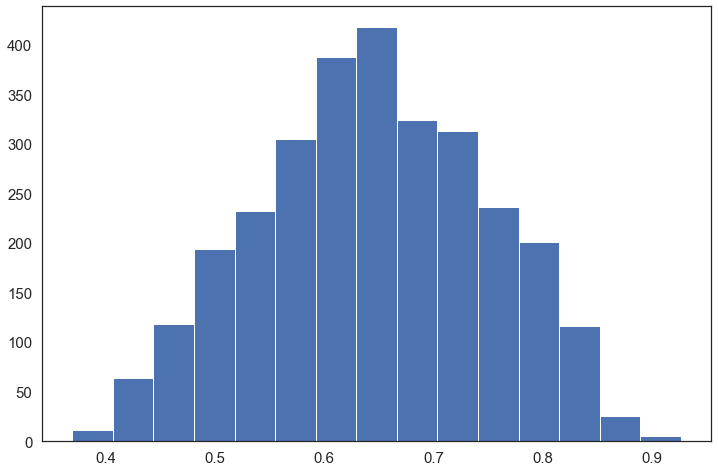

In [21]:
sns.set(style="white")

pd.Series(k_con).hist(bins=15, grid=False, figsize=(12,8), xlabelsize=15, ylabelsize=15)

### Prediction Agreement as Result of SVD

In [22]:
Z = (all_preds_i - all_preds_i.mean(dim=1).unsqueeze(dim=1))/all_preds_i.norm(dim=1).unsqueeze(dim=1)

In [23]:
Z.shape

torch.Size([2951, 20, 6])

In [24]:
k_agr = (torch.linalg.svdvals(Z)[:,0].square()-1)/5

In [25]:
pd.Series(k_agr).describe()

count    2951.000000
mean        0.555627
std         0.151671
min         0.123508
25%         0.452342
50%         0.572696
75%         0.684543
max         0.818802
dtype: float64

<AxesSubplot: >

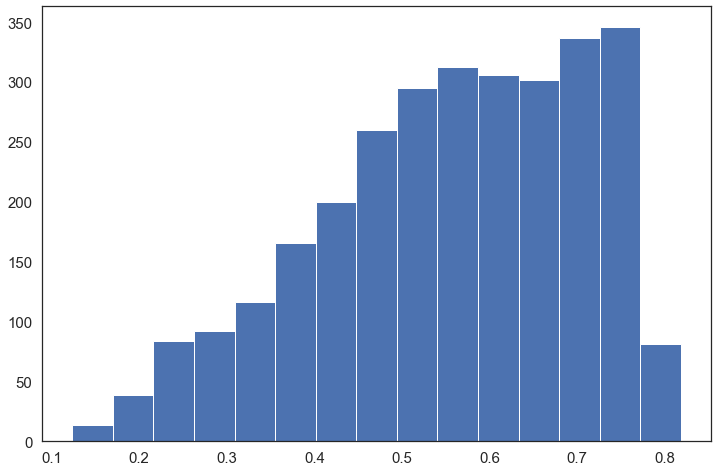

In [26]:
sns.set(style="white")

pd.Series(k_agr).hist(bins=15, grid=False, figsize=(12,8), xlabelsize=15, ylabelsize=15)

In [800]:
all_preds = torch.concat([preds[pred].unsqueeze(dim=0) for pred in preds])
all_preds_i = all_preds.transpose(0,1).transpose(1,2)

In [816]:
k_agr_dict = {}
for i in range(6):
    all_preds_temp = torch.concat([preds[list(preds.keys())[j]].unsqueeze(dim=0) for j in range(len(preds)) if not j==i])
    all_preds_i_temp = all_preds_temp.transpose(0,1).transpose(1,2)
    Z_temp = (all_preds_i_temp - all_preds_i_temp.mean(dim=1).unsqueeze(dim=1))/all_preds_i_temp.norm(dim=1).unsqueeze(dim=1)
    k_agr_temp = (torch.linalg.svdvals(Z_temp)[:,0].square()-1)/4
    k_agr_dict[list(preds.keys())[i]] = pd.Series(k_agr_temp).describe()

In [817]:
k_agr_dict

{'MLP': count    2951.000000
 mean        0.539404
 std         0.154174
 min         0.116632
 25%         0.431249
 50%         0.555127
 75%         0.671022
 max         0.812073
 dtype: float64,
 'GAT': count    2951.000000
 mean        0.536934
 std         0.157488
 min         0.092365
 25%         0.426610
 50%         0.553722
 75%         0.670756
 max         0.811263
 dtype: float64,
 'GCN': count    2951.000000
 mean        0.543522
 std         0.158136
 min         0.070683
 25%         0.444010
 50%         0.564297
 75%         0.676935
 max         0.809565
 dtype: float64,
 'SAGE': count    2951.000000
 mean        0.529684
 std         0.162983
 min         0.072449
 25%         0.419745
 50%         0.548589
 75%         0.667906
 max         0.812107
 dtype: float64,
 'HeteroGNN': count    2951.000000
 mean        0.538210
 std         0.158050
 min         0.083199
 25%         0.428539
 50%         0.556559
 75%         0.673452
 max         0.811317
 dtype: fl

### Saving Aggregated Results

In [27]:
results = pd.DataFrame(torch.hstack([weighted_average, k_con.unsqueeze(dim=1), k_agr.unsqueeze(dim=1)])).rename(columns={20:'Confidence',21:'Agreement'})

In [778]:
results

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Confidence,Agreement,Split
0,0.023308,0.092600,0.013124,0.008048,0.196725,0.106169,0.049425,0.006630,0.503971,0.073991,...,0.016723,0.110538,0.003947,0.002881,0.003196,0.003373,0.008975,0.640173,0.511985,3
1,0.007802,0.028861,0.005184,0.002837,0.035748,0.039839,0.007949,0.002255,0.869525,0.137170,...,0.012703,0.096044,0.004870,0.003663,0.003719,0.004303,0.009441,0.804773,0.758477,1
2,0.046474,0.078024,0.019920,0.013998,0.189559,0.294794,0.076289,0.013048,0.267894,0.152243,...,0.011432,0.131497,0.004096,0.003283,0.002871,0.003469,0.009972,0.541068,0.398835,3
3,0.039600,0.167872,0.037128,0.013169,0.010623,0.062525,0.611162,0.047346,0.010575,0.056670,...,0.021234,0.621870,0.009843,0.006424,0.004495,0.007312,0.009619,0.779347,0.699834,2
4,0.224977,0.389542,0.008062,0.058410,0.010918,0.248220,0.037936,0.010347,0.011587,0.188741,...,0.013952,0.359828,0.005026,0.003659,0.002521,0.003093,0.009433,0.613210,0.462161,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.021323,0.395644,0.141878,0.023077,0.005902,0.021139,0.320682,0.055967,0.014388,0.322753,...,0.018147,0.045551,0.005918,0.004739,0.004198,0.006988,0.011462,0.636219,0.484799,2
2947,0.007031,0.036870,0.279541,0.015145,0.003105,0.003098,0.569580,0.080729,0.004902,0.295648,...,0.017517,0.058423,0.005918,0.004885,0.004262,0.007980,0.011796,0.699740,0.596711,3
2948,0.066964,0.518670,0.059821,0.024642,0.014110,0.028481,0.230130,0.045167,0.012014,0.307637,...,0.021037,0.036960,0.006333,0.005501,0.004894,0.008167,0.011490,0.641245,0.524926,3
2949,0.292696,0.283671,0.057701,0.035209,0.014874,0.188822,0.078696,0.034312,0.014019,0.368661,...,0.013481,0.041714,0.004622,0.004239,0.003453,0.005919,0.012276,0.569789,0.437757,2


In [779]:
results.to_csv(save_dir + 'General_Results/preds.csv',sep='\t')

In [20]:
results = pd.read_csv(save_dir + 'General_Results/preds.csv',sep='\t', index_col = 'Unnamed: 0')

In [21]:
results

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Confidence,Agreement,Split
0,0.023308,0.092600,0.013124,0.008048,0.196725,0.106169,0.049425,0.006630,0.503971,0.073991,...,0.016723,0.110538,0.003947,0.002881,0.003196,0.003373,0.008975,0.640173,0.511985,3
1,0.007802,0.028861,0.005184,0.002837,0.035748,0.039839,0.007949,0.002255,0.869525,0.137170,...,0.012703,0.096044,0.004870,0.003663,0.003719,0.004303,0.009441,0.804773,0.758477,1
2,0.046474,0.078024,0.019920,0.013998,0.189559,0.294794,0.076289,0.013048,0.267894,0.152243,...,0.011432,0.131497,0.004096,0.003283,0.002871,0.003469,0.009972,0.541068,0.398835,3
3,0.039600,0.167872,0.037128,0.013169,0.010623,0.062525,0.611162,0.047346,0.010575,0.056670,...,0.021234,0.621870,0.009843,0.006424,0.004495,0.007312,0.009619,0.779347,0.699834,2
4,0.224977,0.389542,0.008062,0.058410,0.010918,0.248220,0.037936,0.010347,0.011587,0.188741,...,0.013952,0.359828,0.005026,0.003659,0.002521,0.003093,0.009433,0.613210,0.462161,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.021323,0.395644,0.141878,0.023077,0.005902,0.021139,0.320682,0.055967,0.014388,0.322753,...,0.018147,0.045551,0.005918,0.004739,0.004198,0.006988,0.011462,0.636219,0.484799,2
2947,0.007031,0.036870,0.279541,0.015145,0.003105,0.003098,0.569580,0.080729,0.004902,0.295648,...,0.017517,0.058423,0.005918,0.004885,0.004262,0.007980,0.011796,0.699740,0.596711,3
2948,0.066964,0.518670,0.059821,0.024642,0.014110,0.028481,0.230130,0.045167,0.012014,0.307637,...,0.021037,0.036960,0.006333,0.005501,0.004894,0.008167,0.011490,0.641245,0.524926,3
2949,0.292696,0.283671,0.057701,0.035209,0.014874,0.188822,0.078696,0.034312,0.014019,0.368661,...,0.013481,0.041714,0.004622,0.004239,0.003453,0.005919,0.012276,0.569789,0.437757,2


### Evaluating The Aggregated Results

In [22]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [23]:
y_s = np.load('dataset/Venice_homo/raw/labels.npz', allow_pickle=True)
y_att = torch.tensor(y_s['ATT_LAB'][:,1:10].astype(float))
y_val = torch.tensor(np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float)))
ys = torch.tensor(np.hstack([y_att, y_val]))
bool_att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
bool_val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

In [24]:
split = np.load('dataset/Venice_homo/raw/train_val_test_idx.npz')
split_masks = {}
for name in ['train', 'val', 'test']:
    idx = split[f'{name}_idx']
    idx = torch.from_numpy(idx).to(torch.long)
    mask = torch.zeros(ys.shape[0], dtype=torch.bool)
    mask[idx] = True
    split_masks[name] = mask

In [40]:
results

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Confidence,Agreement,Split
0,0.023308,0.092600,0.013124,0.008048,0.196725,0.106169,0.049425,0.006630,0.503971,0.073991,...,0.016723,0.110538,0.003947,0.002881,0.003196,0.003373,0.008975,0.640173,0.511985,3
1,0.007802,0.028861,0.005184,0.002837,0.035748,0.039839,0.007949,0.002255,0.869525,0.137170,...,0.012703,0.096044,0.004870,0.003663,0.003719,0.004303,0.009441,0.804773,0.758477,1
2,0.046474,0.078024,0.019920,0.013998,0.189559,0.294794,0.076289,0.013048,0.267894,0.152243,...,0.011432,0.131497,0.004096,0.003283,0.002871,0.003469,0.009972,0.541068,0.398835,3
3,0.039600,0.167872,0.037128,0.013169,0.010623,0.062525,0.611162,0.047346,0.010575,0.056670,...,0.021234,0.621870,0.009843,0.006424,0.004495,0.007312,0.009619,0.779347,0.699834,2
4,0.224977,0.389542,0.008062,0.058410,0.010918,0.248220,0.037936,0.010347,0.011587,0.188741,...,0.013952,0.359828,0.005026,0.003659,0.002521,0.003093,0.009433,0.613210,0.462161,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.021323,0.395644,0.141878,0.023077,0.005902,0.021139,0.320682,0.055967,0.014388,0.322753,...,0.018147,0.045551,0.005918,0.004739,0.004198,0.006988,0.011462,0.636219,0.484799,2
2947,0.007031,0.036870,0.279541,0.015145,0.003105,0.003098,0.569580,0.080729,0.004902,0.295648,...,0.017517,0.058423,0.005918,0.004885,0.004262,0.007980,0.011796,0.699740,0.596711,3
2948,0.066964,0.518670,0.059821,0.024642,0.014110,0.028481,0.230130,0.045167,0.012014,0.307637,...,0.021037,0.036960,0.006333,0.005501,0.004894,0.008167,0.011490,0.641245,0.524926,3
2949,0.292696,0.283671,0.057701,0.035209,0.014874,0.188822,0.078696,0.034312,0.014019,0.368661,...,0.013481,0.041714,0.004622,0.004239,0.003453,0.005919,0.012276,0.569789,0.437757,2


In [41]:
out = torch.tensor(np.array(results)[:,:-3])
out_att = out[:,:9]
out_val = out[:,9:]
att_node = (bool_att_lab).nonzero().squeeze()
val_node = (bool_val_lab).nonzero().squeeze()

In [42]:
batch_size = ys.shape[0]

In [43]:
(split_masks['val'] * bool_att_lab).sum()

tensor(492)

In [44]:
(split_masks['val'] * bool_val_lab).sum()

tensor(203)

In [45]:
(split_masks['test'] * bool_att_lab).sum()

tensor(503)

In [46]:
(split_masks['test'] * bool_val_lab).sum()

tensor(192)

In [47]:
acc_1_t = compute_1_accuracy(y_att[:batch_size][split_masks['val'] * bool_att_lab], out_att[split_masks['val'] * bool_att_lab])

In [48]:
out_val[split_masks['val'] * bool_val_lab].shape

torch.Size([203, 11])

In [49]:
import torch.nn.functional as F
acc_1_val = compute_1_accuracy(y_val[split_masks['val'] * bool_val_lab], out_val[split_masks['val'] * bool_val_lab])
acc_k_t = compute_k_accuracy(y_val[split_masks['val'] * bool_val_lab], out_val[split_masks['val'] * bool_val_lab], 3)
jac_k_t = compute_jaccard_index(y_val[split_masks['val'] * bool_val_lab], out_val[split_masks['val'] * bool_val_lab], 3)

In [50]:
(acc_1_t, acc_1_val, acc_k_t, jac_k_t)

(97.5609756097561, 84.23645320197043, 99.01477832512316, 0.7676518632860606)

In [73]:
acc_1_t = compute_1_accuracy(y_att[:batch_size][split_masks['test'] * bool_att_lab], out_att[split_masks['test'] * bool_att_lab])

In [75]:
import torch.nn.functional as F
acc_1_val = compute_1_accuracy(y_val[split_masks['test'] * bool_val_lab], out_val[split_masks['test'] * bool_val_lab])
acc_k_t = compute_k_accuracy(y_val[split_masks['test'] * bool_val_lab], out_val[split_masks['test'] * bool_val_lab], 3)
jac_k_t = compute_jaccard_index(y_val[split_masks['test'] * bool_val_lab], out_val[split_masks['test'] * bool_val_lab], 3)

In [76]:
(acc_1_t, acc_1_val, acc_k_t, jac_k_t)

(98.2107355864811, 81.77083333333334, 100.0, 0.7630208333333334)

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [54]:
test_ATT_conf = confusion_matrix(ys[split_masks['test'] * bool_att_lab][:,:9].argmax(axis=1).cpu(), 
                                 out[split_masks['test'] * bool_att_lab][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(ys[split_masks['test'] * bool_val_lab][:,9:].argmax(axis=1).cpu(), 
                                 out[split_masks['test'] * bool_val_lab][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(ys[split_masks['test'] * bool_val_lab][:,9:].cpu(),  
                                out[split_masks['test'] * bool_val_lab][:,9:].cpu(),3)).astype(int)

In [55]:
test_ATT_conf

array([[ 64,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 145,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  10,   0,   0,   0,   0,   1,   0],
       [  1,   0,   0,  17,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  72,   0,   0,   0,   0],
       [  0,   2,   0,   0,   0, 100,   0,   0,   0],
       [  0,   2,   0,   0,   1,   0,  74,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  12]], dtype=int64)

In [56]:
test_VAL_conf

array([[55,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 19,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  5, 21,  3,  0,  4,  0,  0,  0,  0,  0],
       [ 2,  2,  1, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  1,  4,  3,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [57]:
test_VAL_conf_k

array([[ 90,  56,  54,  42,   0,  40,   0,   0,   0,   0,   0],
       [ 50,  87,  76,  63,   0,  33,   0,   0,   0,   0,   0],
       [ 56,  80, 119,  86,   0,  67,   0,   0,   0,   0,   0],
       [ 55,  74,  93, 117,   0,  60,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 45,  36,  74,  70,   0,  84,   0,   0,   0,   0,   0],
       [  1,   0,   2,   0,   0,   2,   1,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [58]:
val_ATT_conf = confusion_matrix(ys[split_masks['val'] * bool_att_lab][:,:9].argmax(axis=1).cpu(), 
                                 out[split_masks['val'] * bool_att_lab][:,:9].argmax(axis=1).cpu(), labels = range(9))
val_VAL_conf = confusion_matrix(ys[split_masks['val'] * bool_val_lab][:,9:].argmax(axis=1).cpu(), 
                                 out[split_masks['val'] * bool_val_lab][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(ys[split_masks['val'] * bool_val_lab][:,9:].cpu(),  
                                out[split_masks['val'] * bool_val_lab][:,9:].cpu(),3)).astype(int)

In [59]:
val_ATT_conf

array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   1,   1,   0,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  21,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  74,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0, 102,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,  60,   0,   0],
       [  1,   0,   2,   0,   0,   0,   0,   2,   0],
       [  0,   1,   0,   0,   1,   0,   0,   0,   8]], dtype=int64)

In [60]:
val_VAL_conf

array([[64,  2,  2,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1, 13,  1,  3,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 24,  4,  0,  3,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 31,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  3,  0,  0, 39,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [61]:
val_VAL_conf_k

array([[102,  65,  61,  51,   0,  45,   0,   0,   0,   0,   0],
       [ 58,  89,  66,  67,   3,  38,   0,   0,   0,   0,   0],
       [ 51,  61, 119,  86,   0,  76,   0,   0,   0,   0,   0],
       [ 65,  84, 101, 116,   3,  57,   0,   0,   0,   0,   0],
       [  0,   8,   5,   8,   3,   0,   0,   0,   0,   0,   0],
       [ 48,  38,  92,  65,   0,  96,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [62]:
ATT_conf = val_ATT_conf + test_ATT_conf
VAL_conf = val_VAL_conf + test_VAL_conf
VAL_conf_k = val_VAL_conf_k + test_VAL_conf_k

In [63]:
ATT_conf

array([[125,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 289,   0,   0,   1,   1,   0,   0,   0],
       [  0,   0,  18,   0,   0,   0,   0,   1,   0],
       [  2,   0,   0,  38,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0, 146,   0,   0,   0,   0],
       [  0,   3,   0,   0,   0, 202,   0,   0,   0],
       [  0,   2,   0,   0,   3,   0, 134,   0,   0],
       [  1,   0,   4,   0,   0,   0,   0,   2,   0],
       [  0,   1,   0,   0,   1,   0,   0,   0,  20]], dtype=int64)

In [64]:
VAL_conf

array([[119,   4,   2,   0,   0,   1,   0,   0,   0,   0,   0],
       [  3,  32,   1,   5,   0,   1,   0,   0,   0,   0,   0],
       [  2,   5,  45,   7,   0,   7,   0,   0,   0,   0,   0],
       [  3,   3,   1,  58,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   5,   7,   3,   0,  73,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

In [65]:
VAL_conf_k

array([[192, 121, 115,  93,   0,  85,   0,   0,   0,   0,   0],
       [108, 176, 142, 130,   3,  71,   0,   0,   0,   0,   0],
       [107, 141, 238, 172,   0, 143,   0,   0,   0,   0,   0],
       [120, 158, 194, 233,   3, 117,   0,   0,   0,   0,   0],
       [  0,  11,   8,  11,   3,   0,   0,   0,   0,   0,   0],
       [ 93,  74, 166, 135,   0, 180,   0,   0,   0,   0,   0],
       [  1,   0,   2,   0,   0,   2,   1,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [66]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(save_dir + 'General_Results/confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(save_dir + 'General_Results/confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(save_dir + 'General_Results/confusion_matrix_VAL_k.csv')

In [67]:
pd.DataFrame(ATT_conf).to_csv(save_dir + 'General_Results/agg_confusion_matrix_ATT.csv')
pd.DataFrame(VAL_conf).to_csv(save_dir + 'General_Results/agg_confusion_matrix_VAL.csv')
pd.DataFrame(VAL_conf_k).to_csv(save_dir + 'General_Results/agg_confusion_matrix_VAL_k.csv')

In [94]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [737]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001 - (k-1)*val)
        recall = val/(col.sum()+0.000000001 - (k-1)*val)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [39]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and\nLand-scape Scenery',
 'Monuments and\nBuildings',
 'Peoples Activity and\nAssociation',
 'Artifact Products',
 'Urban Scenery']

In [97]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [738]:
metrics_dict_s = {}
metrics_dict_s['ATT'] = per_class_metrics(ATT_conf, categories)
metrics_dict_s['VAL'] = per_class_metrics(VAL_conf, classes)
metrics_dict_s['VAL_k'] = per_class_metrics_k(VAL_conf_k, classes)

In [98]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [739]:
metrics_s_df = pd.DataFrame.from_dict({(i,j): metrics_dict_s[i][j] 
                           for i in metrics_dict_s.keys() 
                           for j in metrics_dict_s[i].keys()},
                       orient='index')

In [99]:
metrics_df.to_csv(save_dir + 'General_Results/per_class_metrics.csv')

In [741]:
metrics_s_df.to_csv(save_dir + 'General_Results/agg_per_class_metrics.csv')

In [740]:
metrics_s_df

precision    recall        F1
ATT   Building Elements                          1.000000  0.976562  0.988142
      Urban Form Elements                        0.993127  0.976351  0.984668
      Gastronomy                                 0.947368  0.818182  0.878049
      Interior Scenery                           0.950000  1.000000  0.974359
      Natural Features and\nLand-scape Scenery   0.993197  0.966887  0.979866
      Monuments and\nBuildings                   0.985366  0.995074  0.990196
      Peoples Activity and\nAssociation          0.964029  1.000000  0.981685
      Artifact Products                          0.285714  0.666667  0.400000
      Urban Scenery                              0.909091  1.000000  0.952381
VAL   Criterion i                                0.944444  0.894737  0.918919
      Criterion ii                               0.761905  0.653061  0.703297
      Criterion iii                              0.681818  0.803571  0.737705
      Criterion iv                               0.878788  0.794521  0.834532
      Criterion v                                0.000000  0.000000  0.000000
      Criterion vi                               0.776596  0.879518  0.824859
      Criterion vii                              1.000000  1.000000  1.000000
      Criterion viii                             0.000000  0.000000  0.000000
      Criterion ix                               0.000000  0.000000  0.000000
      Criterion x                                0.000000  0.000000  0.000000
      Others                                     0.000000  0.000000  0.000000
VAL_k Criterion i                                0.864865  0.810127  0.836601
      Criterion ii                               0.633094  0.534954  0.579901
      Criterion iii                              0.732308  0.608696  0.664804
      Criterion iv                               0.649025  0.756494  0.698651
      Criterion v                                0.111111  1.000000  0.200000
      Criterion vi                               0.625000  0.750000  0.681818
      Criterion vii                              0.250000  1.000000  0.400000
      Criterion viii                             0.000000  0.000000  0.000000
      Criterion ix                               0.000000  0.000000  0.000000
      Criterion x                                0.000000  0.000000  0.000000
      Others                                     0.000000  0.000000  0.000000

In [750]:
2 * (ATT_conf/ATT_conf.sum(axis=0) * ATT_conf/(ATT_conf.sum(axis=1)))/(ATT_conf/ATT_conf.sum(axis=0) + ATT_conf/(ATT_conf.sum(axis=1))+0.000000001)

array([[0.98814229, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9846678 , 0.        , 0.        , 0.00671141,
        0.00490196, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.87804878, 0.        , 0.        ,
        0.        , 0.        , 0.2       , 0.        ],
       [0.01581028, 0.        , 0.        , 0.97435897, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00340715, 0.        , 0.        , 0.97986577,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01022146, 0.        , 0.        , 0.        ,
        0.99019608, 0.        , 0.        , 0.        ],
       [0.        , 0.00681431, 0.        , 0.        , 0.02013423,
        0.        , 0.98168498, 0.        , 0.        ],
       [0.00790514, 0.        , 0.19512195, 0.        , 0.        ,
        0.        , 0.        , 0.4       , 0.        ],


In [71]:
ATT_df = pd.DataFrame(2 * (ATT_conf/ATT_conf.sum(axis=0) * ATT_conf/(ATT_conf.sum(axis=1)))/(ATT_conf/ATT_conf.sum(axis=0) + ATT_conf/(ATT_conf.sum(axis=1))+0.000000001), index=categories, columns=categories)

In [40]:
categories_new = ['Monuments and\nBuildings',
                  'Building Elements',
                  'Urban Form Elements',
                  'Urban Scenery',
                  'Natural Features and\nLand-scape Scenery',
                  'Interior Scenery',
                  'Peoples Activity and\nAssociation',
                  'Gastronomy',
                  'Artifact Products']

In [73]:
ATT_df_new = ATT_df[categories_new].T[categories_new].T

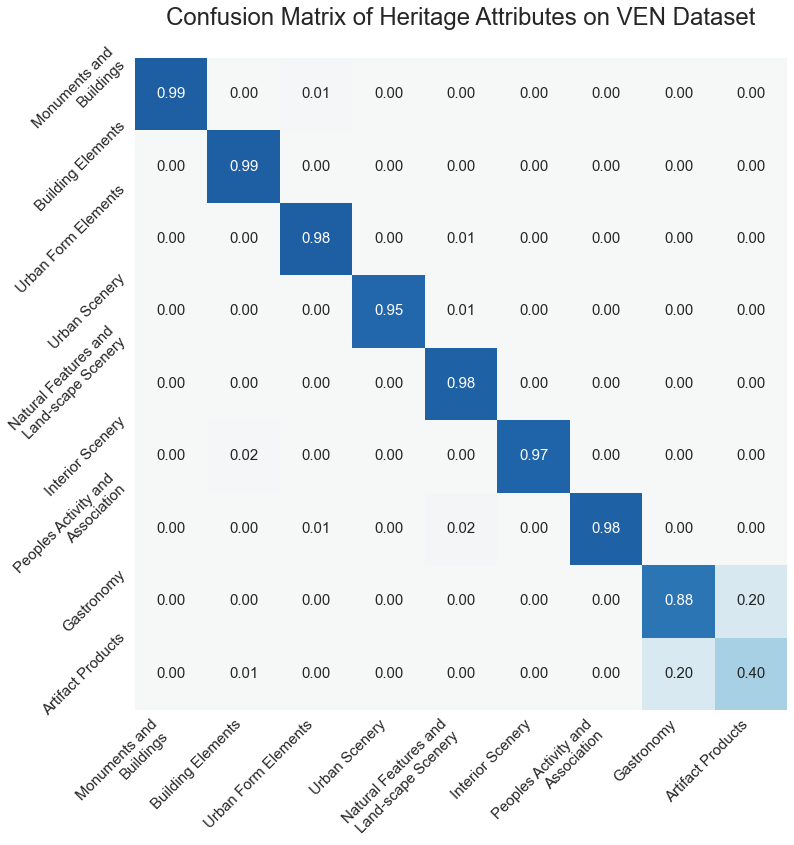

In [754]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(ATT_df_new, annot=True, center=0, annot_kws = {'fontsize':15},
                     vmax=1.2, vmin=0, square=True, fmt='.2f',cmap="RdBu",cbar=False)
    label_x = ax.get_xticklabels()
    label_y = ax.get_yticklabels()
    plt.setp(label_x, horizontalalignment='right', fontsize=15, rotation=45)
    plt.setp(label_y, verticalalignment='center', fontsize=15, rotation=45)
    plt.title('Confusion Matrix of Heritage Attributes on VEN Dataset\n',size=24)
    plt.show()

In [74]:
VAL_df = pd.DataFrame((2*VAL_conf/(VAL_conf.sum(axis=0)+0.0000000001+VAL_conf.sum(axis=1)))[:-1,:-1], 
                      index=classes[:-1], columns=classes[:-1])

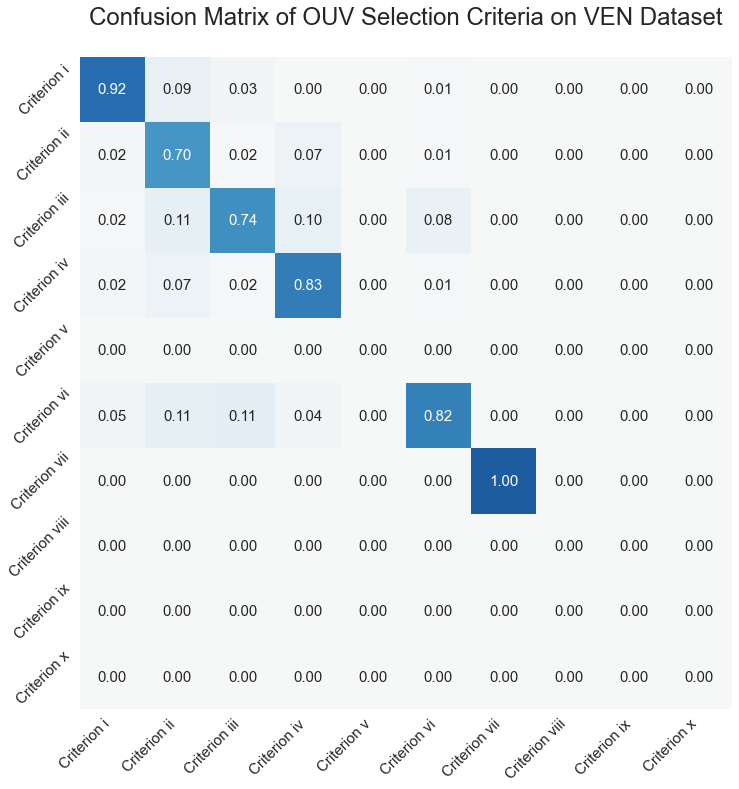

In [75]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(VAL_df, annot=True, center=0, annot_kws = {'fontsize':15},
                     vmax=1.2, vmin=0, square=True, fmt='.2f',cmap="RdBu",cbar=False)
    label_x = ax.get_xticklabels()
    label_y = ax.get_yticklabels()
    plt.setp(label_x, horizontalalignment='right', fontsize=15, rotation=45)
    plt.setp(label_y, verticalalignment='center', fontsize=15, rotation=45)
    plt.title('Confusion Matrix of OUV Selection Criteria on VEN Dataset\n',size=24)
    plt.show()

In [76]:
VAL_conf_k.diagonal()

array([192, 176, 238, 233,   3, 180,   1,   0,   0,   0,   0])

In [77]:
VAL_df_k = pd.DataFrame(2*VAL_conf_k/(VAL_conf_k.sum(axis=1)+0.0000000001-2*VAL_conf_k.diagonal())*VAL_conf_k/(VAL_conf_k.sum(axis=0)+0.0000000001-2*VAL_conf_k.diagonal())/(VAL_conf_k/(VAL_conf_k.sum(axis=0)+0.0000000001-2*VAL_conf_k.diagonal())+VAL_conf_k/(VAL_conf_k.sum(axis=1)+0.0000000001-2*VAL_conf_k.diagonal())+0.00000000001), index=classes, columns=classes)

In [78]:
VAL_df_k = pd.DataFrame((2*VAL_conf_k/(VAL_conf_k.sum(axis=1)+0.0000000001-4*
                                      VAL_conf_k.diagonal()+VAL_conf_k.sum(axis=0)+0.0000000001))[:-1,:-1], 
                        index=classes[:-1], columns=classes[:-1])

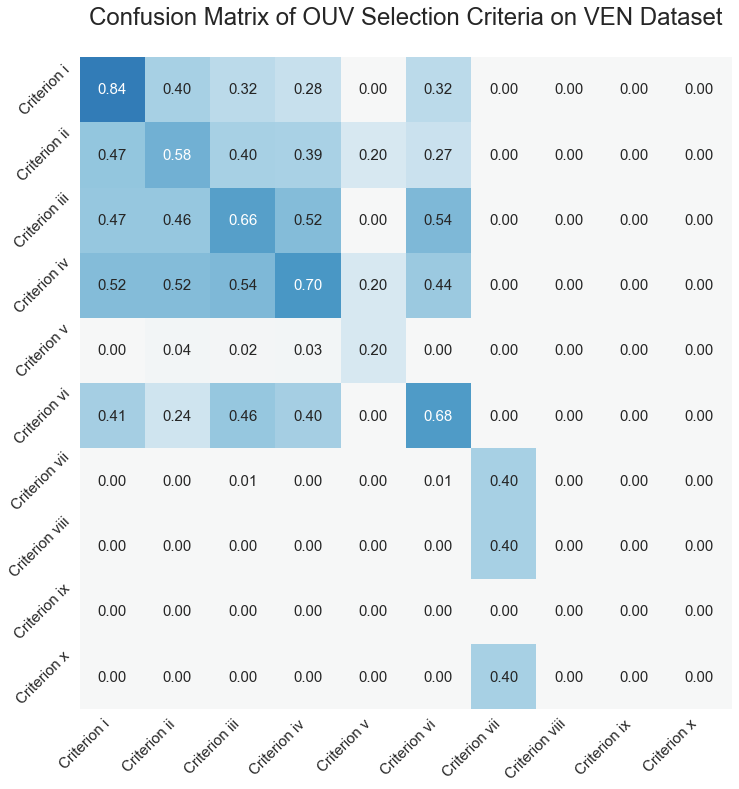

In [79]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(VAL_df_k, annot=True, center=0, annot_kws = {'fontsize':15},
                     vmax=1.2, vmin=0, square=True, fmt='.2f',cmap="RdBu",cbar=False)
    label_x = ax.get_xticklabels()
    label_y = ax.get_yticklabels()
    plt.setp(label_x, horizontalalignment='right', fontsize=15, rotation=45)
    plt.setp(label_y, verticalalignment='center', fontsize=15, rotation=45)
    plt.title('Confusion Matrix of OUV Selection Criteria on VEN Dataset\n',size=24)
    plt.show()

### Statistical Tests of Confidence and Agreement Values

In [134]:
results['Split'] = pd.Series(split_masks['train']*1 + split_masks['val']*2 + split_masks['test']*3).fillna(0)

In [135]:
results['Split']

0       3
1       1
2       3
3       2
4       2
       ..
2946    2
2947    3
2948    3
2949    2
2950    1
Name: Split, Length: 2951, dtype: int64

In [137]:
results

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Confidence,Agreement,Split
0,0.023308,0.092600,0.013124,0.008048,0.196725,0.106169,0.049425,0.006630,0.503971,0.073991,...,0.016723,0.110538,0.003947,0.002881,0.003196,0.003373,0.008975,0.640173,0.511985,3
1,0.007802,0.028861,0.005184,0.002837,0.035748,0.039839,0.007949,0.002255,0.869525,0.137170,...,0.012703,0.096044,0.004870,0.003663,0.003719,0.004303,0.009441,0.804773,0.758477,1
2,0.046474,0.078024,0.019920,0.013998,0.189559,0.294794,0.076289,0.013048,0.267894,0.152243,...,0.011432,0.131497,0.004096,0.003283,0.002871,0.003469,0.009972,0.541068,0.398835,3
3,0.039600,0.167872,0.037128,0.013169,0.010623,0.062525,0.611162,0.047346,0.010575,0.056670,...,0.021234,0.621870,0.009843,0.006424,0.004495,0.007312,0.009619,0.779347,0.699834,2
4,0.224977,0.389542,0.008062,0.058410,0.010918,0.248220,0.037936,0.010347,0.011587,0.188741,...,0.013952,0.359828,0.005026,0.003659,0.002521,0.003093,0.009433,0.613210,0.462161,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.021323,0.395644,0.141878,0.023077,0.005902,0.021139,0.320682,0.055967,0.014388,0.322753,...,0.018147,0.045551,0.005918,0.004739,0.004198,0.006988,0.011462,0.636219,0.484799,2
2947,0.007031,0.036870,0.279541,0.015145,0.003105,0.003098,0.569580,0.080729,0.004902,0.295648,...,0.017517,0.058423,0.005918,0.004885,0.004262,0.007980,0.011796,0.699740,0.596711,3
2948,0.066964,0.518670,0.059821,0.024642,0.014110,0.028481,0.230130,0.045167,0.012014,0.307637,...,0.021037,0.036960,0.006333,0.005501,0.004894,0.008167,0.011490,0.641245,0.524926,3
2949,0.292696,0.283671,0.057701,0.035209,0.014874,0.188822,0.078696,0.034312,0.014019,0.368661,...,0.013481,0.041714,0.004622,0.004239,0.003453,0.005919,0.012276,0.569789,0.437757,2


In [138]:
results.to_csv(save_dir + 'General_Results/preds.csv',sep='\t')

In [133]:
import pingouin as pg

In [143]:
pg.homoscedasticity(data=results, dv='Confidence', group='Split')

,W,pval,equal_var
levene,68.282809,1.098761e-42,False


In [136]:
aov = pg.anova(data=results, dv='Confidence', between='Split', detailed=True)
print(aov)

   Source         SS    DF        MS           F  p-unc       np2
0   Split  15.002643     3  5.000881  851.755365    0.0  0.464402
1  Within  17.302617  2947  0.005871         NaN    NaN       NaN


In [148]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_tukey(data=results, dv='Confidence', between='Split',
                            effsize='hedges')

# Pretty printing of table
pg.print_table(posthoc, floatfmt='.3f')


POST HOC TESTS

    A      B    mean(A)    mean(B)    diff     se        T    p-tukey    hedges
-----  -----  ---------  ---------  ------  -----  -------  ---------  --------
0.000  1.000      0.573      0.795  -0.222  0.005  -48.249      0.000    -2.895
0.000  2.000      0.573      0.666  -0.093  0.004  -25.497      0.000    -1.215
0.000  3.000      0.573      0.667  -0.095  0.004  -25.926      0.000    -1.235
1.000  2.000      0.795      0.666   0.129  0.005   25.910      0.000     1.680
1.000  3.000      0.795      0.667   0.127  0.005   25.595      0.000     1.659
2.000  3.000      0.666      0.667  -0.002  0.004   -0.381      0.981    -0.020



In [149]:
pg.homoscedasticity(data=results, dv='Agreement', group='Split')

,W,pval,equal_var
levene,143.230131,1.229885e-86,False


In [150]:
aov = pg.anova(data=results, dv='Agreement', between='Split', detailed=True)
print(aov)

   Source         SS    DF         MS           F  p-unc       np2
0   Split  30.513710     3  10.171237  802.563444    0.0  0.449641
1  Within  37.348616  2947   0.012673         NaN    NaN       NaN


In [151]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_tukey(data=results, dv='Agreement', between='Split',
                            effsize='hedges')

# Pretty printing of table
pg.print_table(posthoc, floatfmt='.3f')


POST HOC TESTS

    A      B    mean(A)    mean(B)    diff     se        T    p-tukey    hedges
-----  -----  ---------  ---------  ------  -----  -------  ---------  --------
0.000  1.000      0.444      0.741  -0.297  0.007  -43.899      0.000    -2.634
0.000  2.000      0.444      0.604  -0.159  0.005  -29.698      0.000    -1.415
0.000  3.000      0.444      0.604  -0.160  0.005  -29.792      0.000    -1.420
1.000  2.000      0.741      0.604   0.137  0.007   18.798      0.000     1.219
1.000  3.000      0.741      0.604   0.137  0.007   18.729      0.000     1.214
2.000  3.000      0.604      0.604  -0.001  0.006   -0.084      1.000    -0.004



## Computation of Attention Values

In [328]:
Y = torch.tensor(np.array(results)[:,:-3]).T

In [329]:
Y.sum(dim=1)

tensor([456.7970, 715.0536, 106.6004, 170.8862, 330.5870, 534.2380, 449.4819,
         84.0431, 103.3129, 545.8129, 476.0681, 565.5586, 506.2094,  87.5106,
        527.4592,  62.1456,  43.5761,  34.8390,  53.1072,  48.7135],
       dtype=torch.float64)

In [330]:
conf = torch.tensor(results['Confidence'])
agr = torch.tensor(results['Agreement'])

In [331]:
conf

tensor([0.6402, 0.8048, 0.5411,  ..., 0.6412, 0.5698, 0.7323],
       dtype=torch.float64)

In [863]:
k=2
S = (torch.exp(Y * torch.pow(conf,1.0/k) * torch.pow(agr,1.0/k))*1000)/((torch.exp(Y * torch.pow(conf,1.0/k) * torch.pow(agr,1.0/k)).sum(dim=1)).unsqueeze(1))

In [864]:
pd.Series(torch.hstack([S[i,:] for i in range(20)])).describe()

count    59020.000000
mean         0.338868
std          0.035234
min          0.286776
25%          0.326811
50%          0.336187
75%          0.340381
max          0.774231
dtype: float64

<AxesSubplot: >

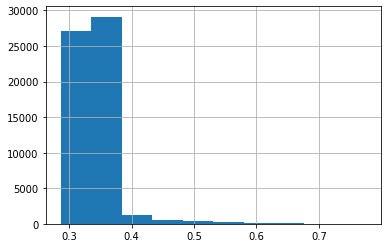

In [865]:
pd.Series(torch.hstack([S[i,:] for i in range(20)])).hist()

<AxesSubplot: >

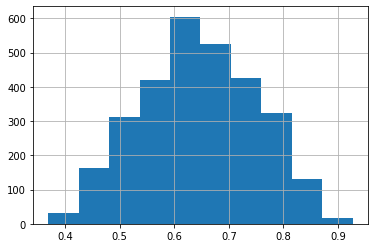

In [824]:
pd.Series(torch.pow(conf,1)).hist()

<AxesSubplot: >

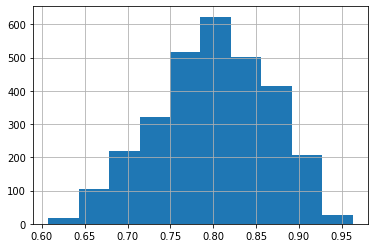

In [222]:
pd.Series(torch.pow(conf,0.5)).hist()

<AxesSubplot: >

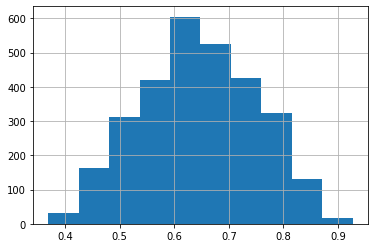

In [223]:
pd.Series(torch.pow(conf,1)).hist()

## Spatial Merging

### Importing Spatial Matrix

In [7]:
import networkx as nx

In [24]:
GEO_metadata = pd.read_csv('dataset/GEO_dataset/Venezia/GEO_metadata.csv', sep='\t', index_col='Unnamed: 0')

In [25]:
GEO_metadata['GEO_node']

0       7636418620
1       7636418620
2       1851468091
3       7887753052
4       4437784469
           ...    
2946     944189018
2947    4878955710
2948    4919658949
2949     944189121
2950     944189412
Name: GEO_node, Length: 2951, dtype: int64

In [26]:
len(GEO_metadata['GEO_node'].unique())

935

In [27]:
GEO_nodes = GEO_metadata['GEO_node'].unique()

In [28]:
GEO_dict = {GEO_nodes[i]:i for i in range(len(GEO_nodes))}

In [29]:
GEO_node_dist = pd.read_csv('dataset/GEO_dataset/Venezia/GEO_node_dist.csv', sep='\t', index_col='Unnamed: 0')

In [30]:
GEO_node_dist_s = GEO_node_dist[GEO_nodes.astype(str)].loc[GEO_nodes]

In [31]:
GEO_node_dist_sym = (np.array(GEO_node_dist_s) + np.array(GEO_node_dist_s).T)/2

In [32]:
W =  torch.tensor(abs(20 - GEO_node_dist_sym)/20 * ((GEO_node_dist_sym<20).astype(float)))

In [33]:
W

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [34]:
W.shape

torch.Size([935, 935])

In [35]:
W.sum()

tensor(8826.0300, dtype=torch.float64)

In [20]:
D = torch.diag(1/(W.sum(dim=0)))

In [21]:
D

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1422, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1487,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1333, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2439]],
       dtype=torch.float64)

In [22]:
D.sum()

tensor(166.4991, dtype=torch.float64)

In [23]:
mapping = torch.tensor(GEO_metadata['GEO_node'].apply(lambda x: GEO_dict[x]))

In [24]:
mapping

tensor([  0,   0,   1,  ..., 459, 932, 930])

In [28]:
B = F.one_hot(mapping).double()

In [29]:
B.shape

torch.Size([2951, 935])

### Computing Initial Labels for the Spatial Nodes

In [351]:
Y_0 = ((S*Y)@B)/(S@B)

In [529]:
Y_00 = torch.vstack([Y_0[:9,:]/(Y_0[:9,:].sum(dim=0)), Y_0[9:,:]/(Y_0[9:,:].sum(dim=0))])

In [409]:
Y

tensor([[0.0233, 0.0078, 0.0465,  ..., 0.0670, 0.2927, 0.0404],
        [0.0926, 0.0289, 0.0780,  ..., 0.5187, 0.2837, 0.7244],
        [0.0131, 0.0052, 0.0199,  ..., 0.0598, 0.0577, 0.0299],
        ...,
        [0.0032, 0.0037, 0.0029,  ..., 0.0049, 0.0035, 0.0044],
        [0.0034, 0.0043, 0.0035,  ..., 0.0082, 0.0059, 0.0080],
        [0.0090, 0.0094, 0.0100,  ..., 0.0115, 0.0123, 0.0122]],
       dtype=torch.float64)

In [530]:
Y_00.shape

torch.Size([20, 935])

In [531]:
Y_00.sum(dim=0)

tensor([2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 

In [378]:
B[:,0]

tensor([1., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [380]:
Y.sum(dim=0)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)

In [384]:
Y[:,0]

tensor([0.0233, 0.0926, 0.0131, 0.0080, 0.1967, 0.1062, 0.0494, 0.0066, 0.5040,
        0.0740, 0.3219, 0.2236, 0.2309, 0.0167, 0.1105, 0.0039, 0.0029, 0.0032,
        0.0034, 0.0090], dtype=torch.float64)

In [385]:
Y[:,1]

tensor([0.0078, 0.0289, 0.0052, 0.0028, 0.0357, 0.0398, 0.0079, 0.0023, 0.8695,
        0.1372, 0.4019, 0.2009, 0.1252, 0.0127, 0.0960, 0.0049, 0.0037, 0.0037,
        0.0043, 0.0094], dtype=torch.float64)

In [388]:
S[:,0]

tensor([0.3084, 0.3020, 0.3338, 0.3276, 0.3516, 0.3180, 0.3161, 0.3350, 0.4426,
        0.3145, 0.3692, 0.3432, 0.3483, 0.3365, 0.3235, 0.3358, 0.3367, 0.3373,
        0.3362, 0.3374], dtype=torch.float64)

In [391]:
S[:,1]

tensor([0.3062, 0.2929, 0.3326, 0.3268, 0.3231, 0.3087, 0.3092, 0.3343, 0.6543,
        0.3355, 0.4203, 0.3533, 0.3365, 0.3366, 0.3273, 0.3363, 0.3371, 0.3377,
        0.3367, 0.3382], dtype=torch.float64)

In [394]:
(Y[:,0] * S[:, 0] + Y[:,1] * S[:, 1]).sum()

tensor(1.7163, dtype=torch.float64)

In [395]:
(S[:, 0] + S[:, 1]).sum()

tensor(13.7375, dtype=torch.float64)

In [398]:
(Y[:,0] * S[:, 0] + Y[:,1] * S[:, 1])/(S[:, 0] + S[:, 1])

tensor([0.0156, 0.0612, 0.0092, 0.0054, 0.1196, 0.0735, 0.0289, 0.0044, 0.7220,
        0.1066, 0.3645, 0.2121, 0.1790, 0.0147, 0.1032, 0.0044, 0.0033, 0.0035,
        0.0038, 0.0092], dtype=torch.float64)

In [413]:
((Y[:,0] * S[:, 0] + Y[:,1] * S[:, 1])/(S[:, 0] + S[:, 1])).sum()

tensor(2.0442, dtype=torch.float64)

In [532]:
Y_00.sum(dim=1)

tensor([134.3601, 280.8075,  36.9616,  43.3592,  89.6926, 154.5140, 140.9645,
         26.8317,  27.5088, 161.3504, 150.3999, 181.6146, 167.9210,  29.4203,
        165.8296,  20.1003,  14.0174,  11.3000,  17.6889,  15.3576],
       dtype=torch.float64)

In [533]:
Y_00.sum()

tensor(1870.0000, dtype=torch.float64)

In [368]:
Y.sum()

tensor(5902.0000, dtype=torch.float64)

<AxesSubplot: >

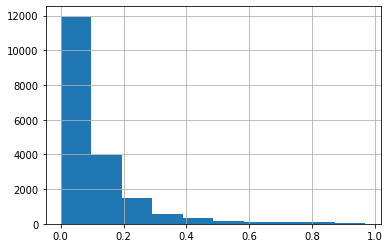

In [534]:
pd.Series(torch.hstack([Y_00[i,:] for i in range(20)])).hist()

<AxesSubplot: >

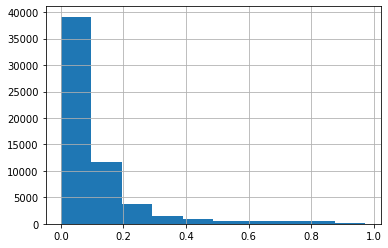

In [359]:
pd.Series(torch.hstack([Y[i,:] for i in range(20)])).hist()

<AxesSubplot: >

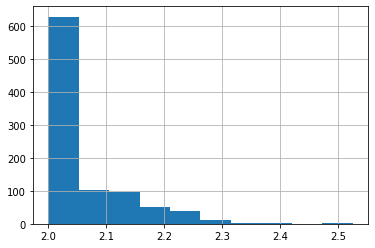

In [416]:
pd.Series(Y_0.sum(dim=0)).hist()

In [535]:
Y_00

tensor([[0.0150, 0.1032, 0.1085,  ..., 0.1292, 0.0604, 0.2071],
        [0.0589, 0.1656, 0.1241,  ..., 0.5298, 0.4326, 0.0736],
        [0.0088, 0.0158, 0.0158,  ..., 0.0649, 0.0240, 0.0083],
        ...,
        [0.0034, 0.0111, 0.0096,  ..., 0.0039, 0.0289, 0.0230],
        [0.0038, 0.0148, 0.0155,  ..., 0.0066, 0.0352, 0.0317],
        [0.0092, 0.0153, 0.0154,  ..., 0.0117, 0.0258, 0.0270]],
       dtype=torch.float64)

In [536]:
Y_1 = 0.9*Y_00 + 0.1 * Y_00@(W@D)

In [537]:
Y_1

tensor([[0.0285, 0.1017, 0.1076,  ..., 0.1297, 0.0609, 0.2032],
        [0.0674, 0.1829, 0.1265,  ..., 0.5068, 0.4260, 0.0956],
        [0.0093, 0.0170, 0.0165,  ..., 0.0654, 0.0249, 0.0094],
        ...,
        [0.0035, 0.0112, 0.0097,  ..., 0.0043, 0.0279, 0.0221],
        [0.0040, 0.0152, 0.0157,  ..., 0.0076, 0.0345, 0.0306],
        [0.0093, 0.0153, 0.0154,  ..., 0.0117, 0.0253, 0.0262]],
       dtype=torch.float64)

In [491]:
W@D

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1422, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1487,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1333, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2439]],
       dtype=torch.float64)

In [500]:
alpha_max = 1/torch.lobpcg(W@D)[0]

In [501]:
alpha_max

tensor([1.0008], dtype=torch.float64)

In [577]:
alpha = 0

In [578]:
Y_n = torch.linalg.solve((torch.eye(len(GEO_nodes)).double() - alpha * W @ D), (1-alpha)*Y_00.T, out=None).T

In [579]:
Y_n

tensor([[0.0150, 0.1032, 0.1085,  ..., 0.1292, 0.0604, 0.2071],
        [0.0589, 0.1656, 0.1241,  ..., 0.5298, 0.4326, 0.0736],
        [0.0088, 0.0158, 0.0158,  ..., 0.0649, 0.0240, 0.0083],
        ...,
        [0.0034, 0.0111, 0.0096,  ..., 0.0039, 0.0289, 0.0230],
        [0.0038, 0.0148, 0.0155,  ..., 0.0066, 0.0352, 0.0317],
        [0.0092, 0.0153, 0.0154,  ..., 0.0117, 0.0258, 0.0270]],
       dtype=torch.float64)

In [580]:
pd.Series(Y_n.sum(dim=0)).describe()

count    9.350000e+02
mean     2.000000e+00
std      2.663584e-16
min      2.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
dtype: float64

<AxesSubplot: >

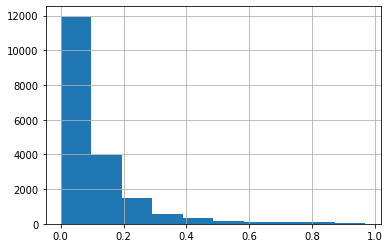

In [581]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).hist()

In [582]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).describe()

count    18700.000000
mean         0.100000
std          0.135222
min          0.000626
25%          0.014445
50%          0.037177
75%          0.151560
max          0.968768
dtype: float64

In [866]:
pd.Series(torch.hstack([Y[i,:] for i in range(20)])).describe()

count    59020.000000
mean         0.100000
std          0.147663
min          0.000515
25%          0.012048
50%          0.034933
75%          0.142669
max          0.972894
dtype: float64

In [570]:
alpha = 0.1

In [571]:
Y_n = torch.linalg.solve((torch.eye(len(GEO_nodes)).double() - alpha * W @ D), (1-alpha)*Y_00.T, out=None).T

In [572]:
Y_n

tensor([[0.0260, 0.1041, 0.1071,  ..., 0.1279, 0.0585, 0.1995],
        [0.0646, 0.1913, 0.1255,  ..., 0.5041, 0.4109, 0.0842],
        [0.0089, 0.0174, 0.0164,  ..., 0.0644, 0.0234, 0.0085],
        ...,
        [0.0034, 0.0113, 0.0097,  ..., 0.0042, 0.0272, 0.0216],
        [0.0038, 0.0153, 0.0157,  ..., 0.0074, 0.0333, 0.0299],
        [0.0091, 0.0156, 0.0153,  ..., 0.0117, 0.0245, 0.0256]],
       dtype=torch.float64)

<AxesSubplot: >

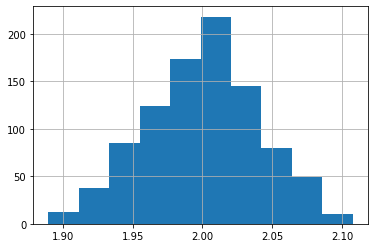

In [573]:
pd.Series(Y_n.sum(dim=0)).hist()

In [574]:
pd.Series(Y_n.sum(dim=0)).describe()

count    935.000000
mean       2.000000
std        0.040388
min        1.889553
25%        1.973270
50%        2.000433
75%        2.026110
max        2.107818
dtype: float64

<AxesSubplot: >

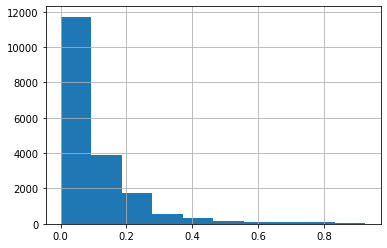

In [575]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).hist()

In [576]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).describe()

count    18700.000000
mean         0.100000
std          0.128979
min          0.001126
25%          0.016365
50%          0.040063
75%          0.152831
max          0.925887
dtype: float64

In [583]:
alpha = 0.9

In [584]:
Y_n = torch.linalg.solve((torch.eye(len(GEO_nodes)).double() - alpha * W @ D), (1-alpha)*Y_00.T, out=None).T

In [585]:
Y_n

tensor([[0.0667, 0.1078, 0.0902,  ..., 0.1218, 0.0576, 0.0748],
        [0.1016, 0.3265, 0.1398,  ..., 0.3114, 0.2175, 0.0995],
        [0.0085, 0.0277, 0.0201,  ..., 0.0631, 0.0177, 0.0111],
        ...,
        [0.0034, 0.0119, 0.0083,  ..., 0.0074, 0.0099, 0.0062],
        [0.0044, 0.0169, 0.0132,  ..., 0.0139, 0.0139, 0.0090],
        [0.0064, 0.0160, 0.0122,  ..., 0.0133, 0.0115, 0.0082]],
       dtype=torch.float64)

<AxesSubplot: >

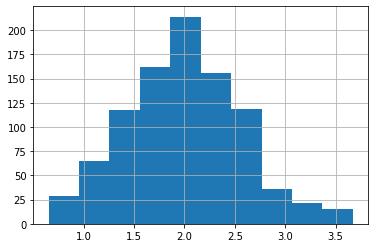

In [586]:
pd.Series(Y_n.sum(dim=0)).hist()

In [587]:
pd.Series(Y_n.sum(dim=0)).describe()

count    935.000000
mean       2.000000
std        0.565152
min        0.651098
25%        1.613665
50%        2.000000
75%        2.353869
max        3.672099
dtype: float64

<AxesSubplot: >

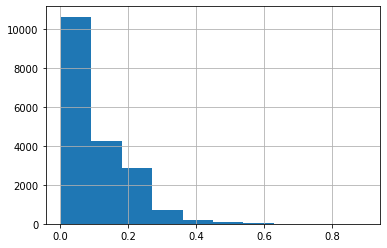

In [588]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).hist()

In [589]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).describe()

count    18700.000000
mean         0.100000
std          0.096559
min          0.002071
25%          0.021189
50%          0.057506
75%          0.165155
max          0.898155
dtype: float64

In [559]:
Y_n[:,0]

tensor([0.0667, 0.1016, 0.0085, 0.0123, 0.0502, 0.0700, 0.0432, 0.0073, 0.1959,
        0.0643, 0.1563, 0.1205, 0.1028, 0.0109, 0.0773, 0.0053, 0.0040, 0.0034,
        0.0044, 0.0064], dtype=torch.float64)

In [590]:
alpha = 0.99

In [591]:
Y_n = torch.linalg.solve((torch.eye(len(GEO_nodes)).double() - alpha * W @ D), (1-alpha)*Y_00.T, out=None).T

In [592]:
Y_n

tensor([[0.0357, 0.1042, 0.0904,  ..., 0.1251, 0.0718, 0.0515],
        [0.0846, 0.2837, 0.1625,  ..., 0.3373, 0.1974, 0.0933],
        [0.0081, 0.0290, 0.0225,  ..., 0.0643, 0.0195, 0.0134],
        ...,
        [0.0030, 0.0102, 0.0069,  ..., 0.0100, 0.0074, 0.0040],
        [0.0043, 0.0149, 0.0107,  ..., 0.0167, 0.0109, 0.0060],
        [0.0043, 0.0138, 0.0100,  ..., 0.0155, 0.0098, 0.0055]],
       dtype=torch.float64)

<AxesSubplot: >

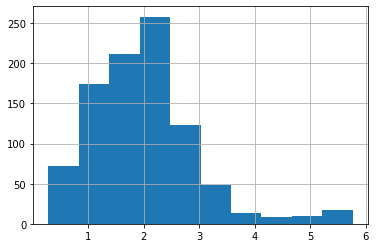

In [593]:
pd.Series(Y_n.sum(dim=0)).hist()

In [594]:
pd.Series(Y_n.sum(dim=0)).describe()

count    935.000000
mean       2.000000
std        0.946412
min        0.285848
25%        1.339657
50%        1.946364
75%        2.432418
max        5.766926
dtype: float64

<AxesSubplot: >

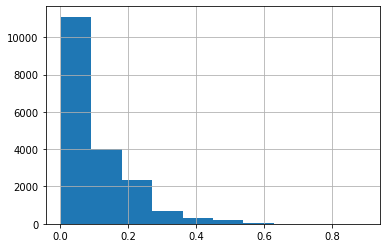

In [595]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).hist()

In [596]:
pd.Series(torch.hstack([Y_n[i,:] for i in range(20)])).describe()

count    18700.000000
mean         0.100000
std          0.105561
min          0.001642
25%          0.020695
50%          0.056410
75%          0.155121
max          0.898155
dtype: float64

In [597]:
Y_n[:,0]

tensor([0.0357, 0.0846, 0.0081, 0.0102, 0.0227, 0.0444, 0.0373, 0.0062, 0.0342,
        0.0431, 0.0567, 0.0562, 0.0516, 0.0082, 0.0472, 0.0051, 0.0037, 0.0030,
        0.0043, 0.0043], dtype=torch.float64)

In [623]:
spatial_y = {}
for a in list(range(0,100,10))+[99]:
    alpha = a/100
    spatial_y[alpha] = torch.linalg.solve((torch.eye(len(GEO_nodes)).double() - alpha * W @ D), 
                                          (1-alpha)*Y_00.T, out=None).T

In [624]:
spatial_vs = pd.DataFrame([pd.Series(torch.hstack([spatial_y[j][i,:] for i in range(20)])).describe() for j in spatial_y])
spatial_vs['alpha'] = pd.Series([j for j in spatial_y])
spatial_vs

,count,mean,std,min,25%,50%,75%,max,alpha
0,18700.0,0.1,0.135222,0.000626,0.014445,0.037177,0.151560,0.968768,0.00
1,18700.0,0.1,0.128979,0.001126,0.016365,0.040063,0.152831,0.925887,0.10
2,18700.0,0.1,0.122986,0.001987,0.017476,0.043432,0.154985,0.898155,0.20
3,18700.0,0.1,0.117302,0.002138,0.018267,0.045944,0.157075,0.898155,0.30
4,18700.0,0.1,0.111998,0.002291,0.019015,0.047901,0.159724,0.898155,0.40
5,18700.0,0.1,0.107169,0.002374,0.019525,0.049447,0.161408,0.898155,0.50
6,18700.0,0.1,0.102937,0.002404,0.019965,0.050759,0.163387,0.898155,0.60
7,18700.0,0.1,0.099479,0.002475,0.020348,0.052563,0.164793,0.898155,0.70
8,18700.0,0.1,0.097093,0.002561,0.020807,0.055168,0.166364,0.898155,0.80
9,18700.0,0.1,0.096559,0.002071,0.021189,0.057506,0.165155,0.898155,0.90


In [627]:
spatial_y_np = {v:np.array(spatial_y[v]) for v in spatial_y}

In [31]:
import pickle

with open(save_dir + 'General_Results/spatial_values.p', 'wb') as handle:
    pickle.dump(spatial_y_np, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
import pickle

with open(save_dir + 'General_Results/spatial_values.p', 'rb') as handle:
    spatial_y_np = pickle.load(handle)
    
spatial_y_np

{0.0: array([[0.01498475, 0.10315842, 0.10849983, ..., 0.12921844, 0.06042162,
         0.20711628],
        [0.05886594, 0.16564131, 0.12411751, ..., 0.52982962, 0.43256143,
         0.07356341],
        [0.0088092 , 0.01580179, 0.01582951, ..., 0.06487809, 0.02400022,
         0.0083248 ],
        ...,
        [0.00344252, 0.01105484, 0.00960167, ..., 0.00392553, 0.02888566,
         0.02297535],
        [0.00382187, 0.01478041, 0.01552884, ..., 0.00656332, 0.03516   ,
         0.03172231],
        [0.00916867, 0.01532814, 0.01536002, ..., 0.01167404, 0.02575558,
         0.02699335]]),
 0.1: array([[0.02603959, 0.10405842, 0.10706645, ..., 0.12787077, 0.0585071 ,
         0.19945691],
        [0.06459974, 0.19134459, 0.12554527, ..., 0.50408842, 0.41085658,
         0.0841774 ],
        [0.00893506, 0.01741685, 0.01637621, ..., 0.06437737, 0.02342307,
         0.00854541],
        ...,
        [0.00339679, 0.01129978, 0.0096724 , ..., 0.00421362, 0.02718229,
         0.0216202 ],
  

## Spatial AutoCorrelation

In [82]:
import esda
import pandas as pd
#import geopandas as gpd
#from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
#from shapely.geometry import Point
%matplotlib inline

C:\Users\Nan\anaconda3\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [200]:
y = pd.Series(spatial_y_np[0.3][0])

In [7]:
spatial_y_np[0.3].shape

(20, 935)

In [608]:
y.shape

(935,)

In [609]:
y.describe()

count    935.000000
mean       0.143701
std        0.058467
min        0.011692
25%        0.099771
50%        0.141401
75%        0.178255
max        0.422622
dtype: float64

In [201]:
y[np.array(Ws.sum(axis=0)!=1)]

0      0.047352
1      0.106108
2      0.104012
3      0.092611
4      0.201552
         ...   
929    0.052891
930    0.062781
932    0.125592
933    0.055045
934    0.181063
Length: 915, dtype: float64

In [202]:
(Ws.sum(axis=0)==1).sum()

tensor(20)

In [37]:
Ws = W

In [38]:
ids_W = Ws.nonzero()
ids_W

tensor([[  0,   0],
        [  0, 497],
        [  0, 681],
        ...,
        [934, 775],
        [934, 824],
        [934, 934]])

In [273]:
neighbours = {}
weights = {}
for a in ids_W:
    s = a[0].item()
    t = a[1].item()
    if not s==t:
        if not s in neighbours:
            neighbours[s] = [t]
            weights[s] = [Ws[s,t].item()]
        else:
            neighbours[s].append(t)
            weights[s].append(Ws[s,t].item())

In [250]:
neighbours = {}
weights = {}
for a in ids_W:
    s = a[0].item()
    t = a[1].item()
    if not s in neighbours:
        neighbours[s] = [t]
        if not s==t:
            weights[s] = [Ws[s,t].item()]
        else:
            weights[s] = [0]
    else:
        neighbours[s].append(t)
        weights[s].append(Ws[s,t].item())

In [277]:
neighbours = {}
weights = {}
for a in ids_W:
    s = a[0].item()
    t = a[1].item()
    if not s in neighbours:
        neighbours[s] = [t]
        if not s==t:
            weights[s] = [Ws[s,t].item()]
        else:
            weights[s] = [1]
    else:
        neighbours[s].append(t)
        weights[s].append(Ws[s,t].item())

In [251]:
Ws[Ws.nonzero(as_tuple=True)]

tensor([1.0000, 0.1300, 0.0650,  ..., 0.5000, 0.0050, 1.0000],
       dtype=torch.float64)

In [278]:
from libpysal.weights import W
w = W(neighbours, weights)

In [268]:
"%.3f"%w.pct_nonzero

'2.483'

In [269]:
w.n

935

In [263]:
w.transform

'O'

In [264]:
w[0]

{497: 0.13000000000000006,
 681: 0.06499999999999986,
 739: 0.03499999999999996,
 842: 0.77}

In [276]:
mi = esda.moran.Moran(y[np.array(Ws.sum(axis=0)!=1)], w, 'r', permutations=9999)
mi.I

0.6651811652012541

In [280]:
mi = esda.moran.Moran(y, w, 'r', permutations=9999)
mi.I

0.7336922377013707

In [217]:
from esda.moran import Moran_Local
lm = Moran_Local(y[np.array(Ws.sum(axis=0)!=1)], w, transformation = "r", permutations = 9999)

In [218]:
.025/985/20

1.269035532994924e-06

In [219]:
1-np.power(1-.025,1/985/20)

1.285167092190953e-06

In [220]:
(lm.p_z_sim<.025/20).sum()

25

In [221]:
(lm.p_z_sim<(1-np.power(1-.025,1/985))).sum()

2

In [222]:
sig = lm.p_z_sim < 1-np.power(1-.025,1/20)
hotspot = sig * lm.q==1
coldspot = sig * lm.q==3
doughnut = sig * lm.q==2
diamond = sig * lm.q==4

In [223]:
hotspot.sum(), coldspot.sum(), doughnut.sum(), diamond.sum()

(11, 0, 14, 0)

In [510]:
mi.sim

array([0.13215687, 0.10923051, 0.09970942, ..., 0.08909595, 0.09011233,
       0.1052201 ])

Text(0.5, 0, "Moran's I")

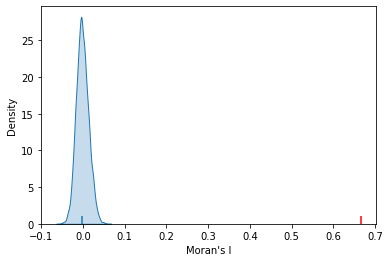

In [224]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [477]:
round(mi.p_sim,5)

0.0001

In [611]:
(mi.I, mi.EI_sim, mi.seI_sim, mi.p_sim, mi.p_z_sim)

(0.8349152041719401, 0.10501233692207806, 0.010605166915034115, 0.0001, 0.0)

In [614]:
Ws

libpysal.weights.weights.W

In [226]:
torch.tensor(y-y.mean()).unsqueeze(0) @ (Ws/Ws.sum(axis=1)) @ torch.tensor(y-y.mean()).unsqueeze(0).T /((torch.tensor(y-y.mean()).unsqueeze(0)) @ torch.tensor(y-y.mean()).unsqueeze(0).T)

tensor([[0.2475]], dtype=torch.float64)

In [249]:
len(Ws) * torch.tensor(y-y.mean()).unsqueeze(0) @ Ws @ torch.tensor(y-y.mean()).unsqueeze(0).T / (Ws.sum()*
                            (torch.tensor(y-y.mean()).unsqueeze(0)) @ torch.tensor(y-y.mean()).unsqueeze(0).T)

tensor([[1.7280]], dtype=torch.float64)

In [126]:
mIs = {}
for i in range(20):
    mIs[i] = {}
    for j in spatial_y_np:
        y = pd.Series(spatial_y_np[j][i])
        mi = esda.moran.Moran(y, w, 'D', permutations=9999)
        mIs[i][j] = (mi.I, mi.EI_sim, mi.seI_sim, mi.p_sim)

In [229]:
import pickle

with open(save_dir + 'General_Results/moran_I_D.p', 'wb') as handle:
    pickle.dump(mIs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [227]:
mIs = {}
for i in range(20):
    mIs[i] = {}
    for j in spatial_y_np:
        y = pd.Series(spatial_y_np[j][i])
        mi = esda.moran.Moran(y[np.array(Ws.sum(axis=0)!=1)], w, 'r', permutations=9999)
        mIs[i][j] = (mi.I, mi.EI_sim, mi.seI_sim, mi.p_sim)

In [228]:
import pickle

with open(save_dir + 'General_Results/moran_I_R.p', 'wb') as handle:
    pickle.dump(mIs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
import pickle

with open(save_dir + 'General_Results/moran_I_D.p', 'rb') as handle:
    mIs = pickle.load(handle)
    
mIs

{0: {0.0: (0.1243729529519435,
   0.10512564653500098,
   0.010372437727835422,
   0.0426),
  0.1: (0.13567654506568189,
   0.10491093939096295,
   0.010385557103327997,
   0.0068),
  0.2: (0.14983961332168738,
   0.10480514818976332,
   0.010482427770289723,
   0.0009),
  0.3: (0.16818570889046322,
   0.10509446238198658,
   0.010478085964940091,
   0.0002),
  0.4: (0.19297037548545556,
   0.10491387616509167,
   0.010347494181758867,
   0.0001),
  0.5: (0.2282791976372637, 0.10492828994581815, 0.010425086958623308, 0.0001),
  0.6: (0.28200655971112565,
   0.10509370590958567,
   0.010588357738231654,
   0.0001),
  0.7: (0.3703173960906754, 0.10517804284098098, 0.010437247072430933, 0.0001),
  0.8: (0.5274422802450865, 0.1049313916339861, 0.010363359869486598, 0.0001),
  0.9: (0.8349152041719401, 0.10501873119634762, 0.01044702457126065, 0.0001),
  0.99: (1.8386949682312455,
   0.10501094950023342,
   0.010429950797141615,
   0.0001)},
 1: {0.0: (0.17776257379118274,
   0.105006481874

In [71]:
import pickle

with open(save_dir + 'General_Results/moran_I_R.p', 'rb') as handle:
    mIs = pickle.load(handle)
    
mIs

{0: {0.0: (0.01772675555780797,
   -0.0012774998205916795,
   0.015161856123295047,
   0.1063),
  0.1: (0.0356461849828101,
   -0.0008757550839504477,
   0.015219019267103392,
   0.0134),
  0.2: (0.05774938474966821,
   -0.001055990975518508,
   0.01514074797794037,
   0.0004),
  0.3: (0.08558160748858774,
   -0.0012476088695208836,
   0.015078525624172645,
   0.0001),
  0.4: (0.12146913865144349,
   -0.0011342085243440264,
   0.014985571413441352,
   0.0001),
  0.5: (0.16895815466292508,
   -0.0009958333942629446,
   0.015075402088379337,
   0.0001),
  0.6: (0.23330956389532692,
   -0.0009824257693370302,
   0.01528120114905684,
   0.0001),
  0.7: (0.3210384675418962,
   -0.001048612716728573,
   0.015061783045125055,
   0.0001),
  0.8: (0.4332520059085963,
   -0.00113871512351028,
   0.014871573224742682,
   0.0001),
  0.9: (0.5413027464518539,
   -0.000826953277004927,
   0.014928395986488862,
   0.0001),
  0.99: (0.6991601548651634,
   -0.0011651571686146674,
   0.01514403002920294

In [72]:
Is = {a:{b:c[0] for b,c in mIs[a].items()} for a in mIs}

In [73]:
SimIs = {a:{b:c[1] for b,c in mIs[a].items()} for a in mIs}
SimSDIs = {a:{b:c[2] for b,c in mIs[a].items()} for a in mIs}
ps = {a:{b:c[-1] for b,c in mIs[a].items()} for a in mIs}

In [74]:
Is_df = pd.DataFrame(Is)
ps_df = pd.DataFrame(ps)
sim_I_df = pd.DataFrame(SimIs)
sim_sd_df = pd.DataFrame(SimSDIs)
Is_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0.00,0.017727,0.093425,0.072915,0.031297,0.190072,0.054663,0.044596,0.045451,0.038252,0.093434,0.105503,0.069729,0.091252,0.078277,0.088917,0.071828,0.068882,0.070463,0.080744,0.050587
0.10,0.035646,0.118104,0.093455,0.050839,0.227193,0.078320,0.065245,0.064372,0.069287,0.122361,0.134690,0.092673,0.119062,0.106068,0.116191,0.097505,0.094941,0.096536,0.106452,0.074706
0.20,0.057749,0.147552,0.118469,0.075025,0.270473,0.107480,0.090468,0.087623,0.106699,0.157402,0.168952,0.118329,0.151937,0.139662,0.148683,0.128582,0.126555,0.128078,0.137610,0.103701
0.30,0.085582,0.182961,0.149405,0.105509,0.321254,0.143980,0.121764,0.116677,0.151973,0.199897,0.208677,0.145919,0.190312,0.180287,0.186945,0.166526,0.165180,0.166522,0.175776,0.138263
0.40,0.121469,0.225746,0.188327,0.144727,0.381171,0.190361,0.161234,0.153655,0.206848,0.250951,0.253415,0.173864,0.233752,0.228986,0.230705,0.213089,0.212445,0.213511,0.222903,0.178448
0.50,0.168958,0.277346,0.238228,0.196324,0.452123,0.250002,0.211781,0.201619,0.273161,0.310419,0.300883,0.200151,0.279963,0.285826,0.277884,0.269990,0.269656,0.270455,0.281138,0.222839
0.60,0.233310,0.338478,0.303453,0.265737,0.536014,0.326757,0.277075,0.264806,0.352361,0.374731,0.345780,0.223864,0.323927,0.348281,0.323660,0.337743,0.336319,0.337189,0.351870,0.267932
0.70,0.321038,0.407074,0.390106,0.360480,0.633754,0.422550,0.360265,0.348016,0.444157,0.434129,0.380140,0.247930,0.359466,0.409207,0.361698,0.412557,0.406865,0.408793,0.432771,0.309905
0.80,0.433252,0.473994,0.505153,0.487022,0.741630,0.529016,0.457655,0.451747,0.542593,0.475129,0.399871,0.282925,0.387263,0.458429,0.391577,0.481246,0.467144,0.471603,0.511547,0.351821
0.90,0.541303,0.524161,0.645645,0.626360,0.836840,0.614705,0.541979,0.557274,0.622367,0.504458,0.426705,0.359784,0.434026,0.501559,0.439031,0.527521,0.506936,0.513743,0.565215,0.420230


In [37]:
sim_I_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0.00,0.105126,0.105006,0.104889,0.104916,0.104925,0.104996,0.104895,0.105143,0.104922,0.105095,0.104884,0.104777,0.105024,0.104916,0.104961,0.105081,0.104827,0.104845,0.104870,0.105032
0.10,0.104911,0.105011,0.105071,0.104877,0.105173,0.105066,0.104950,0.104951,0.105029,0.104983,0.104841,0.104905,0.104910,0.105004,0.104976,0.105029,0.105033,0.105146,0.104848,0.104863
0.20,0.104805,0.104923,0.104986,0.105035,0.105050,0.104933,0.105014,0.104885,0.104792,0.104936,0.105059,0.105090,0.105215,0.104830,0.104840,0.104901,0.104752,0.105106,0.105133,0.104886
0.30,0.105094,0.104966,0.105010,0.104864,0.105084,0.104974,0.104910,0.105115,0.104972,0.104952,0.104990,0.104965,0.104751,0.104919,0.105076,0.104945,0.105000,0.104998,0.104987,0.105009
0.40,0.104914,0.104939,0.104943,0.104879,0.104938,0.104879,0.104945,0.104959,0.104934,0.104998,0.104960,0.104996,0.104978,0.105022,0.104868,0.104980,0.105047,0.104900,0.104905,0.105051
0.50,0.104928,0.104969,0.105037,0.104822,0.105034,0.104939,0.104947,0.104996,0.104857,0.104993,0.104960,0.105010,0.104857,0.105000,0.105077,0.105101,0.104903,0.104951,0.104971,0.104947
0.60,0.105094,0.104948,0.105112,0.104904,0.104823,0.104971,0.104899,0.104989,0.104909,0.104875,0.104902,0.104912,0.105185,0.104880,0.105120,0.104966,0.104949,0.104787,0.104971,0.104997
0.70,0.105178,0.104734,0.104973,0.104772,0.105095,0.104945,0.105020,0.105080,0.105100,0.105151,0.104960,0.105019,0.105084,0.104836,0.105034,0.104862,0.104836,0.104771,0.104962,0.104999
0.80,0.104931,0.105135,0.105016,0.105076,0.104995,0.104895,0.105026,0.104998,0.105200,0.104950,0.104933,0.105097,0.104967,0.105031,0.104861,0.105052,0.105000,0.105016,0.104918,0.105020
0.90,0.105019,0.105024,0.105024,0.104956,0.104875,0.105066,0.105005,0.104960,0.104889,0.104990,0.105099,0.104793,0.104958,0.104971,0.104991,0.104754,0.104896,0.104789,0.105000,0.104914


In [101]:
ps_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0.00,0.0426,0.0001,0.0004,0.0116,0.0001,0.0001,0.0114,0.0198,0.0141,0.0001,0.0001,0.0001,0.0009,0.0001,0.0004,0.0007,0.0003,0.0003,0.0057,0.0012
0.10,0.0068,0.0001,0.0004,0.0015,0.0001,0.0001,0.0015,0.0052,0.0043,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0024,0.0001
0.20,0.0009,0.0001,0.0001,0.0002,0.0001,0.0001,0.0003,0.0019,0.0013,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0011,0.0001
0.30,0.0002,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0012,0.0006,0.0001,0.0001,0.0002,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0005,0.0001
0.40,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0007,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0003,0.0001
0.50,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0002,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0002,0.0001
0.60,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.70,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0002,0.0001
0.80,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.90,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001


In [90]:
np.array(sim_I_df).mean(), np.array(sim_I_df).std()

(-0.0010998298718149025, 0.00015336136697957273)

In [91]:
np.array(sim_sd_df).mean(), np.array(sim_sd_df).std()

(0.01502166560202505, 0.00027439590861482225)

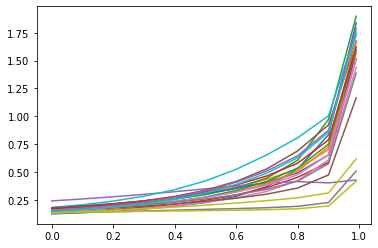

In [247]:
for i in Is_df.T.index:
    Is_df[i].plot(label=i)

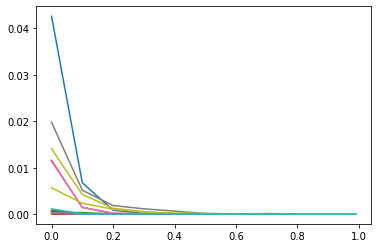

In [248]:
for i in Is_df.T.index:
    ps_df[i].plot()

In [41]:
categories

['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and\nLand-scape Scenery',
 'Monuments and\nBuildings',
 'Peoples Activity and\nAssociation',
 'Artifact Products',
 'Urban Scenery']

In [160]:
sim_I_df.mean(axis=1), sim_sd_df.mean(axis=1)

(0.00    0.104957
 0.10    0.104979
 0.20    0.104958
 0.30    0.104979
 0.40    0.104952
 0.50    0.104965
 0.60    0.104960
 0.70    0.104971
 0.80    0.105006
 0.90    0.104949
 0.99    0.104946
 dtype: float64,
 0.00    0.010230
 0.10    0.010244
 0.20    0.010204
 0.30    0.010196
 0.40    0.010117
 0.50    0.010081
 0.60    0.010040
 0.70    0.009943
 0.80    0.009939
 0.90    0.009886
 0.99    0.009942
 dtype: float64)

In [161]:
np.array(Is_df.index), np.array(sim_I_df.mean(axis=1)-sim_sd_df.mean(axis=1))

(array([0.  , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.99]),
 array([0.09472635, 0.09473537, 0.0947541 , 0.094783  , 0.09483483,
        0.09488413, 0.09492001, 0.09502714, 0.09506724, 0.09506248,
        0.09500428]))

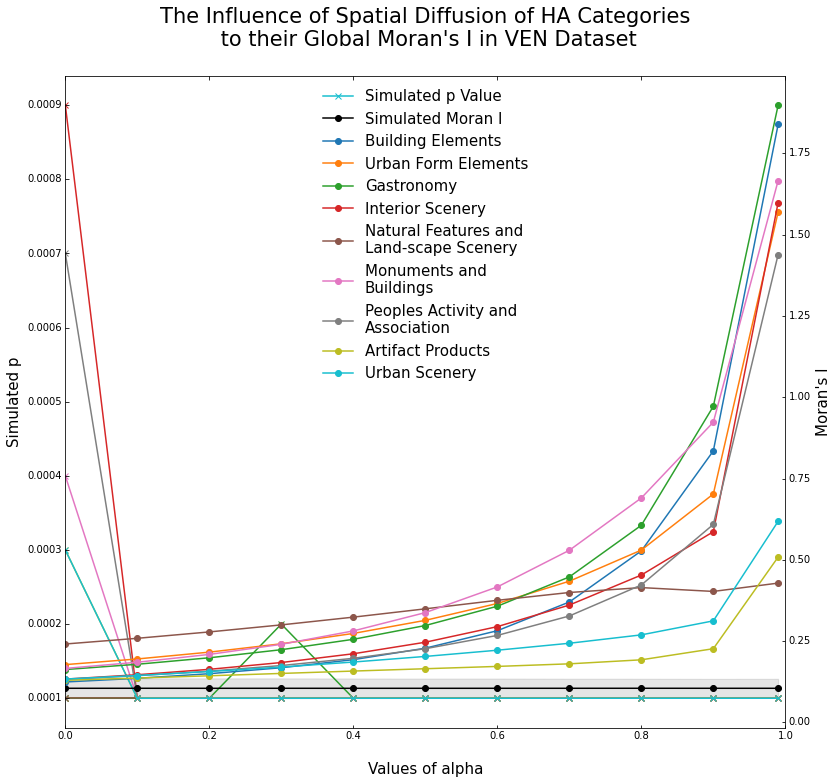

In [165]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=[16,12])
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

c = np.arange(1, 10)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

par1 = host.twinx()

par1.axis["right"].toggle(all=True)
p2, = par1.plot(sim_I_df.iloc[:,:9].mean(axis=1), marker='o', c='k', label='Simulated Moran I')


for i in range(9):
    if not i==8:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x')
    else:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x',label='Simulated p Value')
    p2, = par1.plot(Is_df[i], label=categories[i], c=cmap.to_rgba(i+1), marker='o')
    
par1.fill_between(np.array(Is_df.index), np.array(sim_I_df.iloc[:,:9].mean(axis=1)-3*sim_sd_df.iloc[:,:9].mean(axis=1)), 
                        np.array(sim_I_df.iloc[:,:9].mean(axis=1)+3*sim_sd_df.iloc[:,:9].mean(axis=1)), color='k', alpha=.1)

host.set_xlim(0, 1)
#host.set_ylim(0, .01)
#par1.set_ylim(-0.1, 1)

host.set_xlabel("\nValues of alpha")
host.axis["bottom"].label.set_fontsize(15)
par1.set_ylabel("Moran's I")
par1.axis["right"].label.set_fontsize(15)
host.set_ylabel("Simulated p")
host.axis["left"].label.set_fontsize(15)

host.legend(frameon=False, fontsize=15)

host.set_title("The Influence of Spatial Diffusion of HA Categories\n to their Global Moran's I in VEN Dataset\n", size=21)

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())

plt.show()

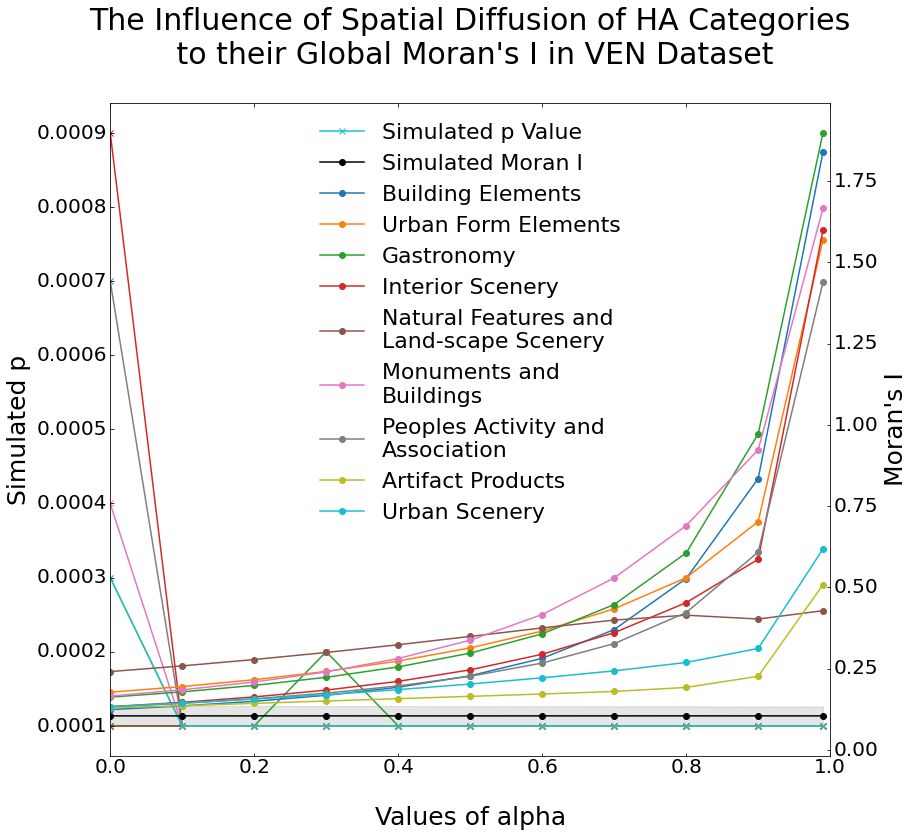

In [67]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=[16,12])
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

c = np.arange(1, 10)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

par1 = host.twinx()

par1.axis["right"].toggle(all=True)
p2, = par1.plot(sim_I_df.iloc[:,:9].mean(axis=1), marker='o', c='k', label='Simulated Moran I')


for i in range(9):
    if not i==8:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x')
    else:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x',label='Simulated p Value')
    p2, = par1.plot(Is_df[i], label=categories[i], c=cmap.to_rgba(i+1), marker='o')
    
par1.fill_between(np.array(Is_df.index), np.array(sim_I_df.iloc[:,:9].mean(axis=1)-3*sim_sd_df.iloc[:,:9].mean(axis=1)), 
                        np.array(sim_I_df.iloc[:,:9].mean(axis=1)+3*sim_sd_df.iloc[:,:9].mean(axis=1)), color='k', alpha=.1)

host.set_xlim(0, 1)
#host.set_ylim(0, .01)
#par1.set_ylim(-0.1, 1)

host.set_xlabel("\nValues of alpha")
host.axis["bottom"].label.set_fontsize(25)
par1.set_ylabel("Moran's I")
par1.axis["right"].label.set_fontsize(25)
host.set_ylabel("Simulated p")
host.axis["left"].label.set_fontsize(25)

host.axis["bottom"].major_ticklabels.set_fontsize(20)
par1.axis["right"].major_ticklabels.set_fontsize(20)
host.axis["left"].major_ticklabels.set_fontsize(20)

host.legend(frameon=False, fontsize=22)

host.set_title("The Influence of Spatial Diffusion of HA Categories\n to their Global Moran's I in VEN Dataset\n",
               size=30)

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())

plt.show()

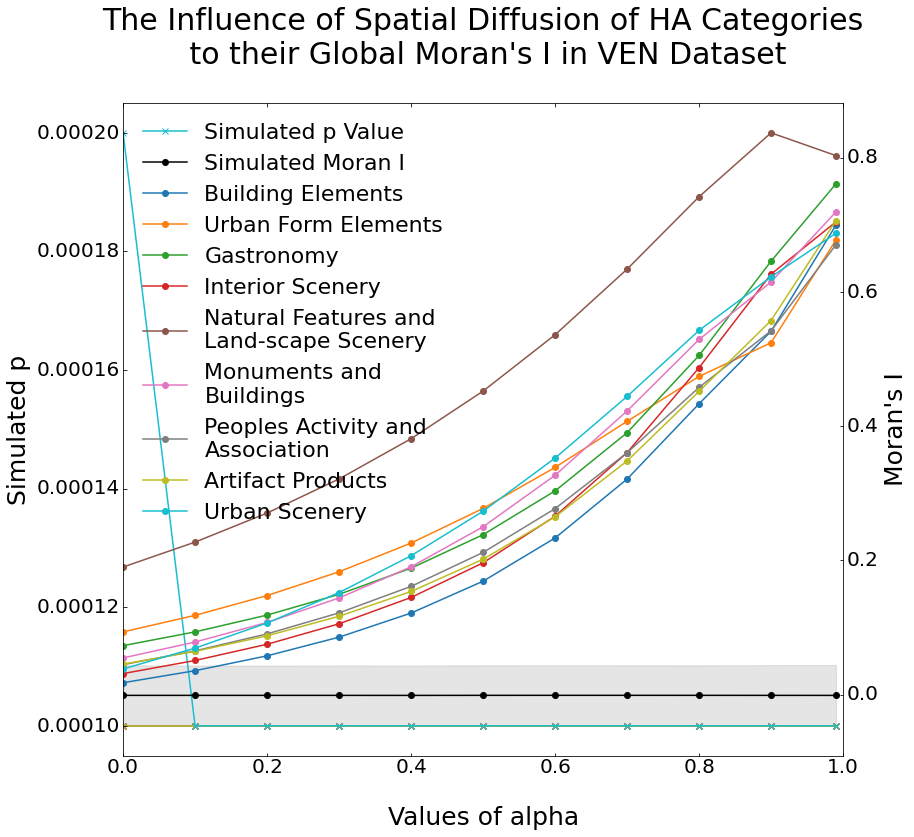

In [75]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=[16,12])
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

c = np.arange(1, 10)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

par1 = host.twinx()

par1.axis["right"].toggle(all=True)
p2, = par1.plot(sim_I_df.iloc[:,:9].mean(axis=1), marker='o', c='k', label='Simulated Moran I')


for i in range(9):
    if not i==8:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x')
    else:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x',label='Simulated p Value')
    p2, = par1.plot(Is_df[i], label=categories[i], c=cmap.to_rgba(i+1), marker='o')
    
par1.fill_between(np.array(Is_df.index), np.array(sim_I_df.iloc[:,:9].mean(axis=1)-3*sim_sd_df.iloc[:,:9].mean(axis=1)), 
                        np.array(sim_I_df.iloc[:,:9].mean(axis=1)+3*sim_sd_df.iloc[:,:9].mean(axis=1)), color='k', alpha=.1)

host.set_xlim(0, 1)
#host.set_ylim(0, .01)
#par1.set_ylim(-0.1, 1)

host.set_xlabel("\nValues of alpha")
host.axis["bottom"].label.set_fontsize(25)
par1.set_ylabel("Moran's I")
par1.axis["right"].label.set_fontsize(25)
host.set_ylabel("Simulated p")
host.axis["left"].label.set_fontsize(25)

host.axis["bottom"].major_ticklabels.set_fontsize(20)
par1.axis["right"].major_ticklabels.set_fontsize(20)
host.axis["left"].major_ticklabels.set_fontsize(20)

host.legend(frameon=False, fontsize=22)

host.set_title("The Influence of Spatial Diffusion of HA Categories\n to their Global Moran's I in VEN Dataset\n",
               size=30)

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())

plt.show()

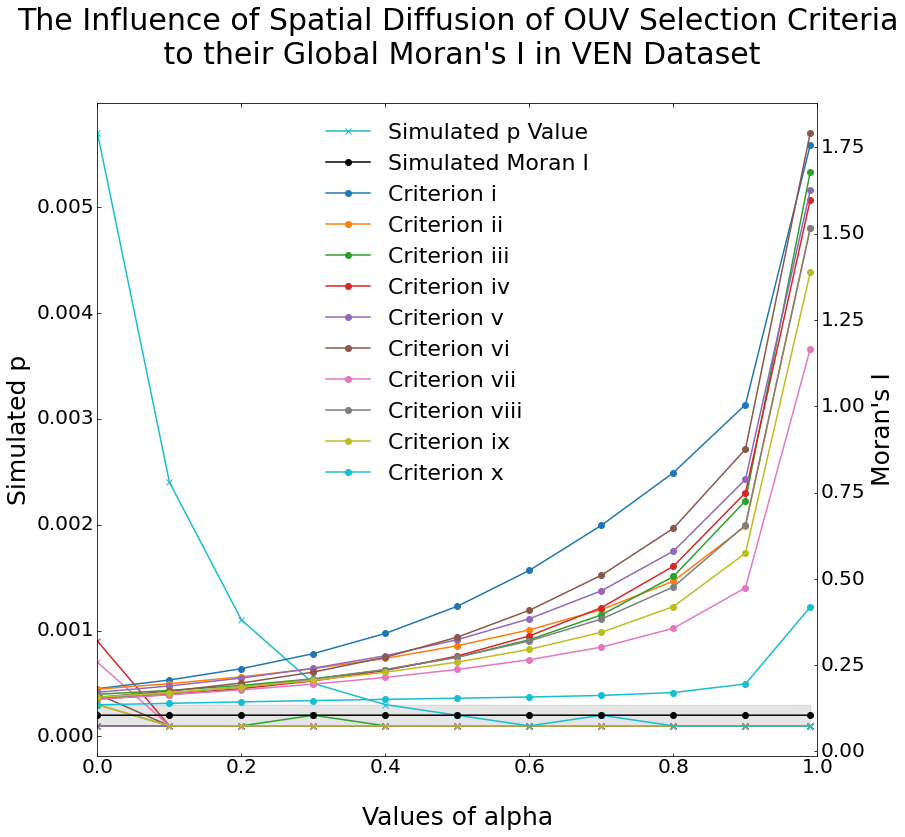

In [70]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=[16,12])
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

c = np.arange(1, 11)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

par1 = host.twinx()

par1.axis["right"].toggle(all=True)
p2, = par1.plot(sim_I_df.iloc[:,9:].mean(axis=1), marker='o', c='k', label='Simulated Moran I')


for i in range(10):
    if not i==9:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x')
    else:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x',label='Simulated p Value')
    p2, = par1.plot(Is_df[i+9], label=classes[i], c=cmap.to_rgba(i+1), marker='o')
    
par1.fill_between(np.array(Is_df.index), np.array(sim_I_df.iloc[:,9:].mean(axis=1)-3*sim_sd_df.iloc[:,9:].mean(axis=1)), 
                        np.array(sim_I_df.iloc[:,9:].mean(axis=1)+3*sim_sd_df.iloc[:,9:].mean(axis=1)), color='k', alpha=.1)

host.set_xlim(0, 1)
#host.set_ylim(0, .01)
#par1.set_ylim(-0.1, 1)

host.set_xlabel("\nValues of alpha")
host.axis["bottom"].label.set_fontsize(25)
par1.set_ylabel("Moran's I")
par1.axis["right"].label.set_fontsize(25)
host.set_ylabel("Simulated p")
host.axis["left"].label.set_fontsize(25)

host.axis["bottom"].major_ticklabels.set_fontsize(20)
par1.axis["right"].major_ticklabels.set_fontsize(20)
host.axis["left"].major_ticklabels.set_fontsize(20)

host.legend(frameon=False, fontsize=22)

host.set_title("The Influence of Spatial Diffusion of OUV Selection Criteria\n to their Global Moran's I in VEN Dataset\n", size=30)

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())

plt.show()

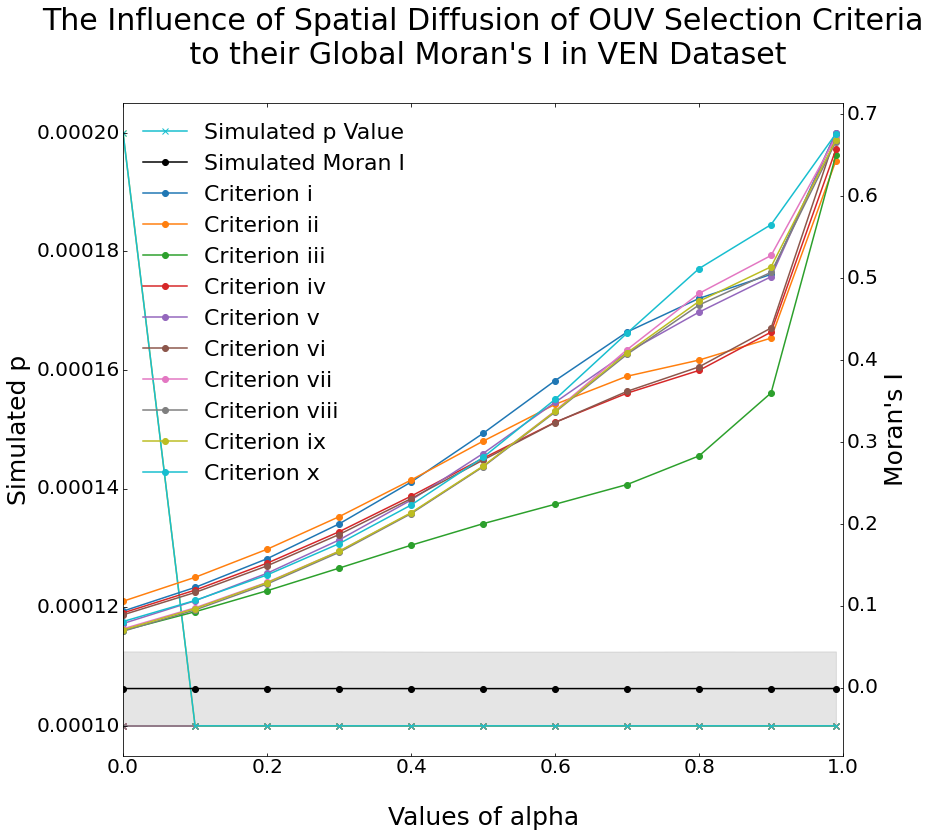

In [76]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=[16,12])
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

c = np.arange(1, 11)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.tab10)
cmap.set_array([])

par1 = host.twinx()

par1.axis["right"].toggle(all=True)
p2, = par1.plot(sim_I_df.iloc[:,9:].mean(axis=1), marker='o', c='k', label='Simulated Moran I')


for i in range(10):
    if not i==9:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x')
    else:
        p1, = host.plot(ps_df[i+9], c=cmap.to_rgba(i+1),marker='x',label='Simulated p Value')
    p2, = par1.plot(Is_df[i+9], label=classes[i], c=cmap.to_rgba(i+1), marker='o')
    
par1.fill_between(np.array(Is_df.index), np.array(sim_I_df.iloc[:,9:].mean(axis=1)-3*sim_sd_df.iloc[:,9:].mean(axis=1)), 
                        np.array(sim_I_df.iloc[:,9:].mean(axis=1)+3*sim_sd_df.iloc[:,9:].mean(axis=1)), color='k', alpha=.1)

host.set_xlim(0, 1)
#host.set_ylim(0, .01)
#par1.set_ylim(-0.1, 1)

host.set_xlabel("\nValues of alpha")
host.axis["bottom"].label.set_fontsize(25)
par1.set_ylabel("Moran's I")
par1.axis["right"].label.set_fontsize(25)
host.set_ylabel("Simulated p")
host.axis["left"].label.set_fontsize(25)

host.axis["bottom"].major_ticklabels.set_fontsize(20)
par1.axis["right"].major_ticklabels.set_fontsize(20)
host.axis["left"].major_ticklabels.set_fontsize(20)

host.legend(frameon=False, fontsize=22)

host.set_title("The Influence of Spatial Diffusion of OUV Selection Criteria\n to their Global Moran's I in VEN Dataset\n", size=30)

#host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())

plt.show()

In [124]:
y_loc = pd.DataFrame(spatial_y_np[0.3])
y_loc

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,934
0,0.047352,0.106108,0.104012,0.092611,0.201552,0.138431,0.110948,0.191379,0.070046,0.094325,...,0.042565,0.059903,0.443085,0.212638,0.052891,0.062781,0.032232,0.125592,0.055045,0.181063
1,0.076009,0.240329,0.128336,0.510710,0.254069,0.119712,0.120905,0.398224,0.192083,0.251763,...,0.358637,0.235262,0.180555,0.202451,0.318938,0.625039,0.624903,0.451758,0.365495,0.103097
2,0.009149,0.020552,0.017399,0.011246,0.021773,0.029690,0.020233,0.024278,0.021453,0.178582,...,0.062085,0.022395,0.018239,0.008379,0.024432,0.038924,0.025647,0.063428,0.022092,0.009048
3,0.008771,0.028411,0.065992,0.045828,0.045304,0.062061,0.025703,0.031229,0.025418,0.064900,...,0.018070,0.022947,0.074155,0.017707,0.017980,0.046763,0.013356,0.042823,0.015747,0.014977
4,0.100352,0.268590,0.039146,0.056466,0.246509,0.188212,0.162037,0.029100,0.315931,0.113192,...,0.024169,0.293585,0.018878,0.014690,0.170465,0.014235,0.087873,0.036337,0.136089,0.018736
5,0.082557,0.143815,0.317338,0.168950,0.097208,0.247541,0.281559,0.327074,0.144592,0.118280,...,0.048700,0.071285,0.179160,0.406536,0.136920,0.075630,0.066255,0.070293,0.136421,0.495832
6,0.033212,0.137828,0.256839,0.092125,0.136964,0.169692,0.246168,0.076067,0.150633,0.064329,...,0.349058,0.214836,0.070363,0.035694,0.163097,0.097716,0.086536,0.140345,0.077846,0.029828
7,0.005832,0.018220,0.024247,0.011323,0.024128,0.033848,0.023330,0.019239,0.020529,0.018798,...,0.044262,0.018834,0.020121,0.010112,0.016982,0.022982,0.010797,0.037304,0.014115,0.009093
8,0.584161,0.088168,0.023291,0.017694,0.025289,0.016348,0.024802,0.021667,0.061874,0.014466,...,0.028845,0.028066,0.011704,0.017921,0.049635,0.011457,0.052401,0.011953,0.057917,0.023135
9,0.098585,0.154651,0.187092,0.233985,0.311783,0.331291,0.175279,0.115938,0.229796,0.149482,...,0.139757,0.108055,0.148576,0.139741,0.138619,0.301892,0.126248,0.314763,0.135760,0.139511


In [ ]:
y_GEO = y_loc.T
y_GEO['id'] = GEO_node_dist_s.index
y_GEO['count'] = GEO_metadata.groupby('GEO_node').count().loc[GEO_nodes]['street_count'].reset_index()['street_count']
y_GEO

In [126]:
y_loc.to_csv(save_dir + 'General_Results/spatial_preds.csv',sep='\t')

In [84]:
y_loc = pd.read_csv(save_dir + 'General_Results/spatial_preds.csv',sep='\t', index_col='Unnamed: 0')

In [85]:
y_loc

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,934
0,0.047352,0.106108,0.104012,0.092611,0.201552,0.138431,0.110948,0.191379,0.070046,0.094325,...,0.042565,0.059903,0.443085,0.212638,0.052891,0.062781,0.032232,0.125592,0.055045,0.181063
1,0.076009,0.240329,0.128336,0.510710,0.254069,0.119712,0.120905,0.398224,0.192083,0.251763,...,0.358637,0.235262,0.180555,0.202451,0.318938,0.625039,0.624903,0.451758,0.365495,0.103097
2,0.009149,0.020552,0.017399,0.011246,0.021773,0.029690,0.020233,0.024278,0.021453,0.178582,...,0.062085,0.022395,0.018239,0.008379,0.024432,0.038924,0.025647,0.063428,0.022092,0.009048
3,0.008771,0.028411,0.065992,0.045828,0.045304,0.062061,0.025703,0.031229,0.025418,0.064900,...,0.018070,0.022947,0.074155,0.017707,0.017980,0.046763,0.013356,0.042823,0.015747,0.014977
4,0.100352,0.268590,0.039146,0.056466,0.246509,0.188212,0.162037,0.029100,0.315931,0.113192,...,0.024169,0.293585,0.018878,0.014690,0.170465,0.014235,0.087873,0.036337,0.136089,0.018736
5,0.082557,0.143815,0.317338,0.168950,0.097208,0.247541,0.281559,0.327074,0.144592,0.118280,...,0.048700,0.071285,0.179160,0.406536,0.136920,0.075630,0.066255,0.070293,0.136421,0.495832
6,0.033212,0.137828,0.256839,0.092125,0.136964,0.169692,0.246168,0.076067,0.150633,0.064329,...,0.349058,0.214836,0.070363,0.035694,0.163097,0.097716,0.086536,0.140345,0.077846,0.029828
7,0.005832,0.018220,0.024247,0.011323,0.024128,0.033848,0.023330,0.019239,0.020529,0.018798,...,0.044262,0.018834,0.020121,0.010112,0.016982,0.022982,0.010797,0.037304,0.014115,0.009093
8,0.584161,0.088168,0.023291,0.017694,0.025289,0.016348,0.024802,0.021667,0.061874,0.014466,...,0.028845,0.028066,0.011704,0.017921,0.049635,0.011457,0.052401,0.011953,0.057917,0.023135
9,0.098585,0.154651,0.187092,0.233985,0.311783,0.331291,0.175279,0.115938,0.229796,0.149482,...,0.139757,0.108055,0.148576,0.139741,0.138619,0.301892,0.126248,0.314763,0.135760,0.139511


In [293]:
y_GEO.to_csv(save_dir + 'General_Results/spatial_preds_GEO.csv',sep='\t')

<AxesSubplot:>

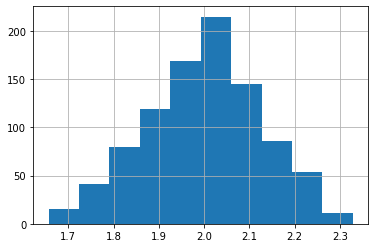

In [129]:
y_loc.sum().hist()

In [524]:
lm.p_z_sim, lm.q, lm.Is

(array([1.59024585e-01, 7.86387547e-02, 1.60768099e-01, 3.87209804e-01,
        5.44833955e-03, 3.15503059e-01, 1.14906961e-01, 2.14048898e-01,
        3.21403249e-01, 6.21149141e-02, 0.00000000e+00, 3.49304077e-01,
        1.99817372e-01, 2.05886846e-01, 4.14893836e-01, 2.02264074e-01,
        4.21898140e-01, 3.84660127e-01, 2.22799528e-01, 3.33576910e-02,
        2.88504666e-01, 1.11983835e-02, 4.20018637e-01, 4.13105239e-01,
        0.00000000e+00, 4.18958558e-01, 1.69354720e-01, 3.75032339e-01,
        4.53700290e-01, 7.21733837e-02, 4.83740174e-01, 4.78471628e-01,
        1.87085493e-01, 3.25807161e-01, 1.66690046e-01, 4.82230294e-01,
        4.64553591e-02, 4.68466233e-01, 2.07333992e-01, 4.85270038e-02,
        4.04583446e-01, 3.43206857e-01, 2.20693391e-01, 4.81083380e-01,
        4.59771837e-02, 3.16456859e-02, 1.52006856e-01, 3.56705541e-01,
        1.36540845e-01, 2.87895285e-02, 6.05256443e-03, 1.61764576e-01,
        7.21268188e-02, 2.81482054e-01, 1.71788724e-01, 1.537193

In [527]:
loc_Is = {}
for i in range(20):
    y = pd.Series(y_loc.T[i])
    lm = Moran_Local(y, w, transformation = "d", permutations = 9999)
    loc_Is[i] = (lm.p_z_sim, lm.q, lm.Is)

/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: divide by zero encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: divide by zero encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: divide by zero encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: divide by zero encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: divide by zero encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/nbai/opt/miniconda3/lib/python3.9/site-packages/esda/moran

In [530]:
import pickle

with open(save_dir + 'General_Results/local_moran_I_D.p', 'wb') as handle:
    pickle.dump(loc_Is, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
import pickle

with open(save_dir + 'General_Results/local_moran_I_D.p', 'rb') as handle:
    loc_Is = pickle.load(handle)
    
loc_Is[0][0]

array([1.71870059e-01, 7.77774385e-02, 1.59378145e-01, 3.94945989e-01,
       6.46589829e-03, 3.19479709e-01, 1.21221114e-01, 2.14703586e-01,
       3.15961901e-01, 6.40479220e-02, 0.00000000e+00, 3.47413816e-01,
       1.98032758e-01, 2.13791004e-01, 4.16065762e-01, 2.09224928e-01,
       4.29484595e-01, 3.85194657e-01, 2.23139654e-01, 3.50678836e-02,
       2.87335909e-01, 1.28691093e-02, 4.20882665e-01, 4.10189150e-01,
       0.00000000e+00, 4.15474365e-01, 1.71675243e-01, 3.78585235e-01,
       4.52602956e-01, 7.70135494e-02, 4.75340712e-01, 4.88159955e-01,
       1.81384763e-01, 3.25643311e-01, 1.68905365e-01, 4.88876099e-01,
       4.47769181e-02, 4.65522024e-01, 2.11605937e-01, 4.97417769e-02,
       4.05262628e-01, 3.49160798e-01, 2.18795663e-01, 4.77339589e-01,
       4.72726990e-02, 3.40065575e-02, 1.53810841e-01, 3.60809444e-01,
       1.34206597e-01, 2.97435220e-02, 6.29214095e-03, 1.72484184e-01,
       7.07564387e-02, 2.76984464e-01, 1.76874150e-01, 1.54041197e-04,
      

In [78]:
loc_ps = pd.DataFrame({a:b[0] for a, b in loc_Is.items()})
loc_qs = pd.DataFrame({a:b[1] for a, b in loc_Is.items()})
loc_Is = pd.DataFrame({a:b[2] for a, b in loc_Is.items()})

In [79]:
loc_ps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.171870,0.307482,0.331385,0.396843,0.398239,0.450836,0.313021,0.347955,0.003528,1.352782e-01,0.050910,0.168540,0.401162,0.111247,3.470222e-01,0.119279,0.096706,0.113319,0.232642,0.077089
1,0.077777,0.155282,0.289098,0.296140,0.421587,0.066568,0.059473,0.365307,0.233399,6.333907e-02,0.420544,0.075350,0.122319,0.161750,4.560297e-01,0.329110,0.396996,0.404499,0.494228,0.302496
2,0.159378,0.015199,0.236340,0.201782,0.380333,0.129893,0.037938,0.335760,0.035638,1.724078e-01,0.041237,0.372338,0.071916,0.406183,1.134349e-05,0.452387,0.345105,0.250079,0.399466,0.339143
3,0.394946,0.037836,0.052175,0.041890,0.011307,0.189751,0.429168,0.106480,0.378838,2.248610e-01,0.232206,0.256853,0.013872,0.082014,4.944608e-01,0.205474,0.085325,0.048154,0.135923,0.054105
4,0.006466,0.262756,0.137829,0.222485,0.006263,0.201817,0.052392,0.258081,0.145432,7.012138e-02,0.200419,0.152409,0.163559,0.339318,3.898675e-01,0.195241,0.033774,0.119912,0.337260,0.015802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0.359319,0.230244,0.053445,0.000005,0.054839,0.000577,0.001610,0.000485,0.033655,7.483934e-09,0.000639,0.122518,0.271907,0.000183,2.719739e-09,0.009500,0.000869,0.002209,0.179244,0.002104
931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
932,0.436720,0.330300,0.055595,0.000138,0.377163,0.000876,0.009256,0.001347,0.041415,2.420462e-07,0.013568,0.077840,0.237900,0.001259,7.934016e-06,0.096773,0.010353,0.018054,0.393352,0.009146
933,0.073582,0.223347,0.403362,0.308605,0.100571,0.246596,0.483670,0.287999,0.120074,2.476341e-01,0.257867,0.456491,0.369697,0.126353,3.917509e-01,0.053881,0.034182,0.052962,0.187054,0.033076


In [80]:
loc_Is

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.000002,0.000193,0.000042,0.000047,-5.943150e-07,0.000035,0.000127,0.000068,0.028585,0.000219,0.001432,0.000027,-4.211990e-07,3.061138e-04,0.000219,3.027943e-04,4.105877e-04,0.000321,0.000108,0.000483
1,0.000093,-0.000051,0.000043,0.000036,2.481880e-04,0.000051,-0.000030,0.000031,0.000509,-0.000071,0.000073,-0.000148,7.465706e-05,7.783306e-05,0.000035,-2.722737e-06,-7.364364e-07,-0.000002,0.000002,0.000006
2,0.000077,0.000491,0.000066,0.000062,-8.822092e-06,0.000412,0.000389,-0.000009,-0.000064,-0.000036,0.000351,0.000087,4.699120e-04,3.799206e-05,0.002047,7.128478e-07,1.860166e-05,0.000062,0.000011,0.000031
3,-0.000017,-0.000472,0.000246,-0.000005,-2.077861e-04,0.000008,-0.000005,0.000219,-0.000020,0.000287,-0.000082,0.000114,3.905111e-05,3.322665e-04,0.000010,8.829617e-05,2.042868e-04,0.000349,0.000131,0.000421
4,0.000304,0.000043,0.000082,-0.000003,8.618049e-04,0.000133,0.000044,0.000023,0.000031,0.001121,-0.000004,-0.000026,5.456425e-05,5.680859e-07,-0.000007,-8.924397e-05,-2.338170e-04,-0.000147,-0.000023,-0.000323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,-0.000006,0.000028,-0.000003,0.000006,2.623670e-04,0.000532,-0.000249,-0.000120,0.000219,0.002615,0.000173,0.000209,-2.022611e-05,8.506086e-04,0.003425,6.316577e-04,9.027042e-04,0.000799,0.000122,0.000678
931,0.000084,0.000296,0.000005,0.000027,4.134608e-07,0.000060,0.000027,0.000029,0.000044,0.000046,0.000008,0.000023,2.153482e-05,1.075013e-04,0.000001,3.967496e-04,6.980249e-04,0.000603,0.000059,0.000488
932,0.000007,-0.000008,0.000145,-0.000042,5.375900e-05,0.000541,-0.000040,0.000173,0.000200,0.002566,0.000178,0.000025,1.853899e-05,8.656282e-04,0.002401,3.820283e-04,7.307917e-04,0.000617,0.000055,0.000617
933,0.000214,0.000053,0.000018,0.000059,7.327884e-05,0.000029,0.000029,-0.000020,0.000203,-0.000028,0.000123,0.000109,4.126900e-05,3.382372e-04,0.000126,4.076595e-04,8.299828e-04,0.000758,0.000109,0.000465


In [81]:
sig = loc_ps < 1-np.power(1-.025,1/20)
hotspot = sig * loc_qs==1
coldspot = sig * loc_qs==3
doughnut = sig * loc_qs==2
diamond = sig * loc_qs==4

In [82]:
hotspot.sum(), coldspot.sum(), doughnut.sum(), diamond.sum()

(0     16
 1     34
 2     44
 3     38
 4     51
 5     45
 6     27
 7     21
 8     18
 9     68
 10    47
 11    38
 12    44
 13    54
 14    32
 15    26
 16    34
 17    38
 18    22
 19    32
 dtype: int64,
 0     16
 1     14
 2     13
 3     16
 4     11
 5     32
 6     13
 7     11
 8     12
 9     27
 10    16
 11    20
 12    17
 13    23
 14    32
 15     7
 16    18
 17    15
 18     6
 19    16
 dtype: int64,
 0     14
 1     11
 2     11
 3     19
 4      9
 5     21
 6     12
 7      7
 8      3
 9     17
 10    14
 11     6
 12    13
 13    16
 14    12
 15     4
 16     9
 17     9
 18     3
 19    12
 dtype: int64,
 0     0
 1     1
 2     0
 3     0
 4     0
 5     0
 6     0
 7     0
 8     0
 9     0
 10    0
 11    2
 12    0
 13    1
 14    1
 15    0
 16    1
 17    1
 18    0
 19    1
 dtype: int64)

<AxesSubplot:>

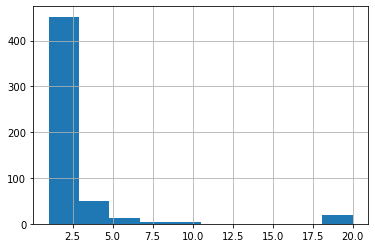

In [109]:
(sig.sum(axis=1)[sig.sum(axis=1)>0]).hist()

In [110]:
hotspot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
931,False,True,False,False,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True,True
932,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
933,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [130]:
y_loc.T.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000
mean,0.143701,0.300329,0.039531,0.046374,0.095928,0.165256,0.150764,0.028697,0.029421,0.172567,0.160856,0.194240,0.179595,0.031466,0.177358,0.021498,0.014992,0.012086,0.018919,0.016425
std,0.129368,0.200702,0.065365,0.067876,0.133341,0.135688,0.132356,0.035262,0.036872,0.072561,0.056870,0.043312,0.057819,0.014114,0.058480,0.013819,0.008047,0.006863,0.020552,0.004811
min,0.008674,0.012006,0.003495,0.003692,0.003331,0.004758,0.009759,0.003299,0.003281,0.027708,0.013905,0.052359,0.023591,0.005712,0.039736,0.002571,0.002362,0.002138,0.002381,0.006231
25%,0.061141,0.141062,0.016442,0.018550,0.020529,0.068164,0.063924,0.013260,0.013950,0.128310,0.127940,0.167979,0.150478,0.018992,0.145628,0.010576,0.007815,0.006158,0.008955,0.012165
50%,0.093662,0.235160,0.023263,0.026680,0.039915,0.113731,0.102384,0.019253,0.021400,0.154166,0.148052,0.192011,0.170881,0.030123,0.171808,0.019829,0.013752,0.010767,0.016466,0.015620
75%,0.178060,0.430311,0.036032,0.042845,0.103038,0.224679,0.188612,0.031465,0.033707,0.202714,0.180314,0.212901,0.189726,0.042710,0.200136,0.030055,0.021132,0.017308,0.025730,0.020921
max,0.759652,0.848185,0.697282,0.645870,0.898155,0.721354,0.684530,0.773969,0.609407,0.561698,0.440426,0.386178,0.532277,0.093670,0.541083,0.167108,0.047215,0.070161,0.526924,0.026987


In [121]:
categories[::-1]

['Urban Scenery',
 'Artifact Products',
 'Peoples Activity and\nAssociation',
 'Monuments and\nBuildings',
 'Natural Features and\nLand-scape Scenery',
 'Interior Scenery',
 'Gastronomy',
 'Urban Form Elements',
 'Building Elements']

In [86]:
y_loc_HA = y_loc.T.iloc[:,0:9].rename(columns = {i:categories[i] for i in range(len(categories))})[categories_new[::-1]]
y_loc_HA

,Artifact Products,Gastronomy,Peoples Activity and\nAssociation,Interior Scenery,Natural Features and\nLand-scape Scenery,Urban Scenery,Urban Form Elements,Building Elements,Monuments and\nBuildings
0,0.005832,0.009149,0.033212,0.008771,0.100352,0.584161,0.076009,0.047352,0.082557
1,0.018220,0.020552,0.137828,0.028411,0.268590,0.088168,0.240329,0.106108,0.143815
2,0.024247,0.017399,0.256839,0.065992,0.039146,0.023291,0.128336,0.104012,0.317338
3,0.011323,0.011246,0.092125,0.045828,0.056466,0.017694,0.510710,0.092611,0.168950
4,0.024128,0.021773,0.136964,0.045304,0.246509,0.025289,0.254069,0.201552,0.097208
...,...,...,...,...,...,...,...,...,...
930,0.022982,0.038924,0.097716,0.046763,0.014235,0.011457,0.625039,0.062781,0.075630
931,0.010797,0.025647,0.086536,0.013356,0.087873,0.052401,0.624903,0.032232,0.066255
932,0.037304,0.063428,0.140345,0.042823,0.036337,0.011953,0.451758,0.125592,0.070293
933,0.014115,0.022092,0.077846,0.015747,0.136089,0.057917,0.365495,0.055045,0.136421


In [87]:
y_loc_HV = y_loc.T.iloc[:,9:].rename(columns = {i+9:classes[i] for i in range(len(classes))})[classes[::-1]]
y_loc_HV

,Others,Criterion x,Criterion ix,Criterion viii,Criterion vii,Criterion vi,Criterion v,Criterion iv,Criterion iii,Criterion ii,Criterion i
0,0.008804,0.003784,0.003321,0.003238,0.004314,0.104525,0.014032,0.171589,0.204517,0.330685,0.098585
1,0.016136,0.016387,0.011782,0.014874,0.021041,0.204319,0.026842,0.163754,0.224648,0.197585,0.154651
2,0.015189,0.015853,0.009773,0.013614,0.021186,0.284620,0.025922,0.117858,0.167268,0.118225,0.187092
3,0.012993,0.011753,0.008054,0.011612,0.017374,0.195640,0.022445,0.182830,0.174619,0.135649,0.233985
4,0.013054,0.010609,0.007157,0.010190,0.013203,0.148819,0.018436,0.167905,0.189710,0.161929,0.311783
...,...,...,...,...,...,...,...,...,...,...,...
930,0.012060,0.009269,0.004883,0.006268,0.007924,0.049574,0.018190,0.189669,0.221766,0.174033,0.301892
931,0.026406,0.033734,0.027917,0.034966,0.047356,0.183254,0.045214,0.154388,0.174846,0.145672,0.126248
932,0.011690,0.009063,0.004796,0.005844,0.008196,0.058331,0.015935,0.173177,0.197628,0.180410,0.314763
933,0.021732,0.029300,0.023541,0.028668,0.036229,0.125626,0.046868,0.155494,0.154917,0.122629,0.135760


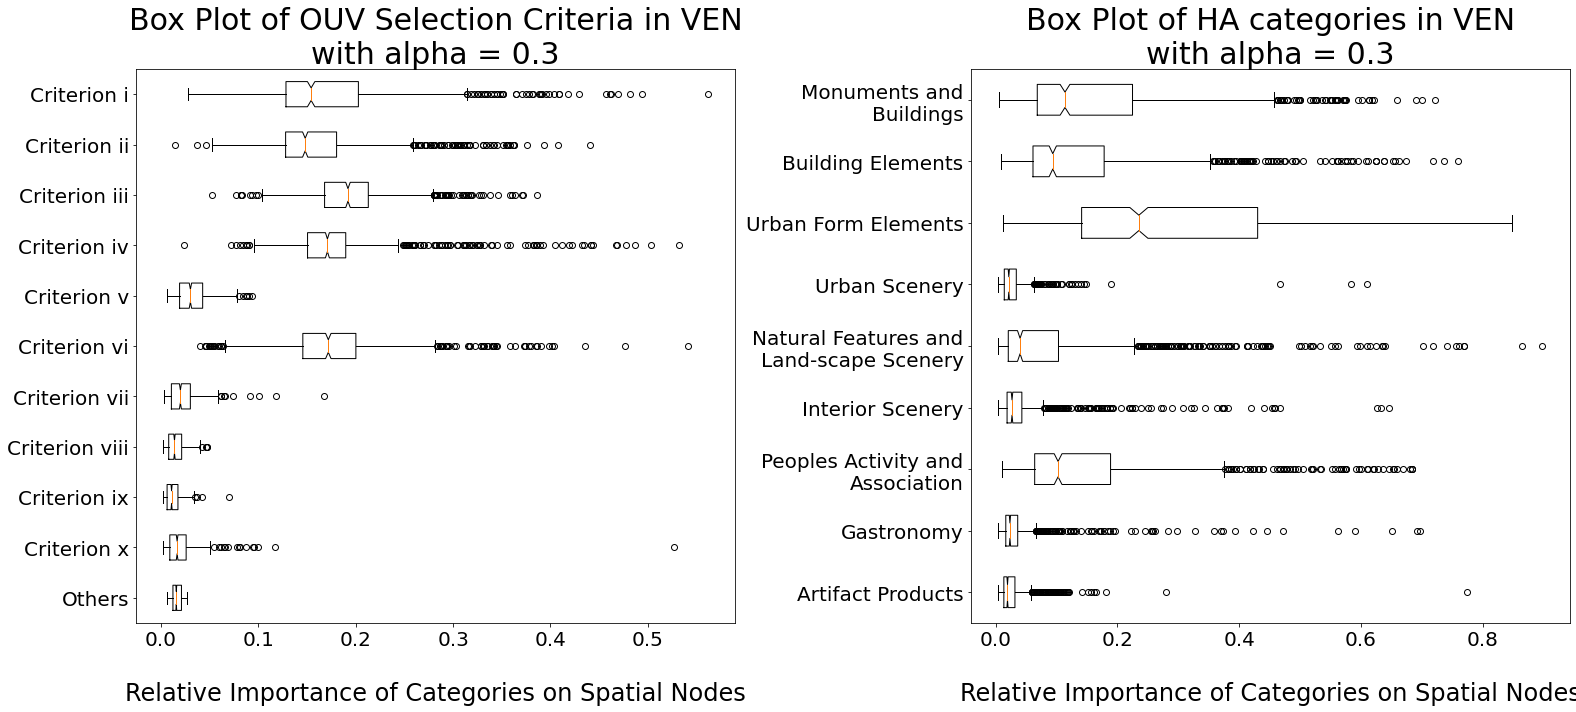

In [102]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22,10))

# plot violin plot
axs[0].boxplot(y_loc_HV, vert=False, notch=True, labels=classes[::-1])
axs[0].set_title('Box Plot of OUV Selection Criteria in VEN\nwith alpha = 0.3', size=30)

# plot box plot
axs[1].boxplot(y_loc_HA, vert=False, notch=True, labels=categories_new[::-1])
axs[1].set_title('Box Plot of HA categories in VEN\nwith alpha = 0.3', size=30)

# adding horizontal grid lines
for ax in axs:
#    ax.yaxis.grid(True)
#    ax.set_xticks([y + 1 for y in range(len(all_data))],
#                  labels=['x1', 'x2', 'x3', 'x4'])
    ax.set_xlabel('\nRelative Importance of Categories on Spatial Nodes', size=24)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
#    ax.set_ylabel('Observed values')
fig.tight_layout()

plt.show()